MrBeam is composed of various software packages: 
-> ehtim (for the general handling of VLBI data)
-> regpy (tool for inverse problems)
-> WISE (tool for a wavelet based analysis of images)
-> MSI (multiscale operator handling)
-> imagingbase (containing the new VLBI imaging capabilities)

In this tutorial we will present some of the key features of regpy: we show how we can invert the Volterra operator with regpy.

In [12]:
#Load basic modules and setup logger
import numpy as np
import logging
import matplotlib.pyplot as plt

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

First we define the forward operator (i.e. the Volterra operator). We have to define a proper domain and codomain first, in this case we just use a uniform grid.

In [13]:
from regpy.discrs import UniformGrid
from regpy.operators.volterra import Volterra

grid = UniformGrid(np.linspace(0, 2*np.pi, 200))
op = Volterra(grid, exponent=3)

Now we can create synthetic data and add noise. The discretization implementation has some helper functions (coords, randn, ones, ...) for this purpose.

In [14]:
exact_solution = np.sin(op.domain.coords[0])
exact_data = op(exact_solution)
noise = 0.03 * op.domain.randn()
data = exact_data + noise
init = op.domain.ones()

We are equipping the operator "op: domain --> codomain" with a Hilbert space structure. The inner product and the respective Gram matrices will be inserted in the inversion procedure automatically. Here we are using a L2 codomain and a smooth domain (Sobolev with index 2).

In [15]:
from regpy.solvers import HilbertSpaceSetting
from regpy.hilbert import L2, Sobolev
setting = HilbertSpaceSetting(op=op, Hdomain=Sobolev(index=2), Hcodomain=L2)

Now we are defining the regularization technique: an irgnm_cg inversion.

In [16]:
from regpy.solvers.irgnm import IrgnmCG
solver = IrgnmCG(setting, data, regpar=1, regpar_step=0.9, init=init.copy())

We specify a stopping rule: stopping by maximal number of iterations or by the discrepancy principle.

In [17]:
import regpy.stoprules as rules
stoprule = (
    rules.CountIterations(max_iterations=100) +
    rules.Discrepancy(
        setting.Hcodomain.norm, data,
        noiselevel=setting.Hcodomain.norm(noise),
        tau=1.1
    )
)

Run the inversion procedure with this stopping rule and display the result.

2023-11-22 10:19:12,641 INFO IrgnmCG              :: Running Tikhonov solver.
2023-11-22 10:19:12,647 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:12,648 INFO CountIterations      :: iteration = 1 / 100
2023-11-22 10:19:12,649 INFO Discrepancy          :: relative discrepancy = 34.08671128548545, tolerance = 1.1
2023-11-22 10:19:12,649 INFO IrgnmCG              :: Running Tikhonov solver.
2023-11-22 10:19:12,657 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:12,658 INFO CountIterations      :: iteration = 2 / 100
2023-11-22 10:19:12,659 INFO Discrepancy          :: relative discrepancy = 17.730802136729558, tolerance = 1.1
2023-11-22 10:19:12,662 INFO IrgnmCG              :: Running Tikhonov solver.
2023-11-22 10:19:12,667 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:12,668 INFO CountIterations      :: iteration = 3 / 100
2023-11-22 10:19:12,669 INFO Discrepancy          :: relative discrepancy = 22.07851922926068, tolerance = 1.1


2023-11-22 10:19:13,025 INFO Discrepancy          :: relative discrepancy = 5.2870752132053145, tolerance = 1.1
2023-11-22 10:19:13,026 INFO IrgnmCG              :: Running Tikhonov solver.
2023-11-22 10:19:13,038 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:13,040 INFO CountIterations      :: iteration = 26 / 100
2023-11-22 10:19:13,041 INFO Discrepancy          :: relative discrepancy = 5.5565689302641035, tolerance = 1.1
2023-11-22 10:19:13,043 INFO IrgnmCG              :: Running Tikhonov solver.
2023-11-22 10:19:13,055 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:13,056 INFO CountIterations      :: iteration = 27 / 100
2023-11-22 10:19:13,057 INFO Discrepancy          :: relative discrepancy = 5.189400886109382, tolerance = 1.1
2023-11-22 10:19:13,058 INFO IrgnmCG              :: Running Tikhonov solver.
2023-11-22 10:19:13,068 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:13,071 INFO CountIterations      :: iteration = 28 / 

2023-11-22 10:19:13,417 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:13,419 INFO CountIterations      :: iteration = 50 / 100
2023-11-22 10:19:13,420 INFO Discrepancy          :: relative discrepancy = 1.526167455239344, tolerance = 1.1
2023-11-22 10:19:13,421 INFO IrgnmCG              :: Running Tikhonov solver.
2023-11-22 10:19:13,435 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:13,436 INFO CountIterations      :: iteration = 51 / 100
2023-11-22 10:19:13,437 INFO Discrepancy          :: relative discrepancy = 1.5039737545392668, tolerance = 1.1
2023-11-22 10:19:13,437 INFO IrgnmCG              :: Running Tikhonov solver.
2023-11-22 10:19:13,452 INFO TikhonovCG           :: Solver converged.
2023-11-22 10:19:13,455 INFO CountIterations      :: iteration = 52 / 100
2023-11-22 10:19:13,457 INFO Discrepancy          :: relative discrepancy = 1.374017923658026, tolerance = 1.1
2023-11-22 10:19:13,459 INFO IrgnmCG              :: Running Tikhonov solve

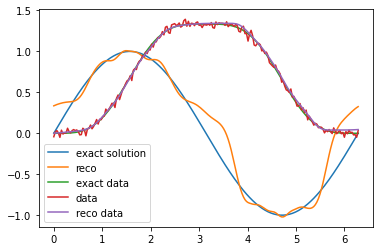

In [18]:
reco, reco_data = solver.run(stoprule)

plt.plot(grid.coords[0], exact_solution.T, label='exact solution')
plt.plot(grid.coords[0], reco, label='reco')
plt.plot(grid.coords[0], exact_data, label='exact data')
plt.plot(grid.coords[0], data, label='data')
plt.plot(grid.coords[0], reco_data, label='reco data')
plt.legend()
plt.show()

IRGNM_CG is gradient based solver. However, not all data fidelity terms and penalty terms possess a uniquely defined gradient (e.g. total variation, L1, ...). Therefore, we provide a framework for convex optimization of general objective functionals in imagingbase. Here we present TV regularization:

In [19]:
from regpy.functionals import TV, HilbertNorm

data_fidelity_operator = op - data
data_fidelity = HilbertNorm(setting.Hcodomain) * data_fidelity_operator
"""The penalty term: 1/2 * ||f||_{TV}^2"""
penalty = TV(setting.Hdomain.discr, Hdomain=setting.Hdomain)

This also demonstrates another property of regpy: operators can be added, multiplied with constant factors and combined with functionals or other operators. The respective gradients and derivatives by the chain rule are handled by regpy internally. This makes it most easy to work with operator combinations or operators/functionals on product spaces.

We do the minimization by the proximal-point based FISTA algorithm. The proximal point algorithm of the TV penalty term is computed by the Chambolle-Pock algorithm.

In [20]:
from regpy.solvers.fista import FISTA

"""Parameters for the inner computation of the proximal operator with the Chambolle algorithm"""
proximal_pars = {
        'stepsize' : 0.001,
        'maxiter' : 100
        }

tau = 0.01
alpha = 0.01

solver = FISTA(setting, data_fidelity, penalty, init.copy(), tau = tau, regpar = alpha, proximal_pars=proximal_pars)

As above we define a stopping rule, run the minimization and display the result:

2023-11-22 08:35:08,106 INFO CountIterations      :: iteration = 1 / 100000
2023-11-22 08:35:08,114 INFO Discrepancy          :: relative discrepancy = 26.52465892419444, tolerance = 1.3
2023-11-22 08:35:08,188 INFO CountIterations      :: iteration = 2 / 100000
2023-11-22 08:35:08,188 INFO Discrepancy          :: relative discrepancy = 25.047862539586635, tolerance = 1.3
2023-11-22 08:35:08,253 INFO CountIterations      :: iteration = 3 / 100000
2023-11-22 08:35:08,253 INFO Discrepancy          :: relative discrepancy = 23.7272902553935, tolerance = 1.3
2023-11-22 08:35:08,318 INFO CountIterations      :: iteration = 4 / 100000
2023-11-22 08:35:08,318 INFO Discrepancy          :: relative discrepancy = 22.602837895883038, tolerance = 1.3
2023-11-22 08:35:08,389 INFO CountIterations      :: iteration = 5 / 100000
2023-11-22 08:35:08,391 INFO Discrepancy          :: relative discrepancy = 21.652939042414044, tolerance = 1.3
2023-11-22 08:35:08,462 INFO CountIterations      :: iteration 

2023-11-22 08:35:11,068 INFO CountIterations      :: iteration = 45 / 100000
2023-11-22 08:35:11,068 INFO Discrepancy          :: relative discrepancy = 14.488044036361723, tolerance = 1.3
2023-11-22 08:35:11,158 INFO CountIterations      :: iteration = 46 / 100000
2023-11-22 08:35:11,158 INFO Discrepancy          :: relative discrepancy = 14.47373258057699, tolerance = 1.3
2023-11-22 08:35:11,230 INFO CountIterations      :: iteration = 47 / 100000
2023-11-22 08:35:11,238 INFO Discrepancy          :: relative discrepancy = 14.460159140223094, tolerance = 1.3
2023-11-22 08:35:11,308 INFO CountIterations      :: iteration = 48 / 100000
2023-11-22 08:35:11,313 INFO Discrepancy          :: relative discrepancy = 14.447270658940294, tolerance = 1.3
2023-11-22 08:35:11,367 INFO CountIterations      :: iteration = 49 / 100000
2023-11-22 08:35:11,375 INFO Discrepancy          :: relative discrepancy = 14.43502091823796, tolerance = 1.3
2023-11-22 08:35:11,432 INFO CountIterations      :: iter

2023-11-22 08:35:13,681 INFO Discrepancy          :: relative discrepancy = 14.206257237648812, tolerance = 1.3
2023-11-22 08:35:13,746 INFO CountIterations      :: iteration = 89 / 100000
2023-11-22 08:35:13,746 INFO Discrepancy          :: relative discrepancy = 14.20353972174322, tolerance = 1.3
2023-11-22 08:35:13,811 INFO CountIterations      :: iteration = 90 / 100000
2023-11-22 08:35:13,811 INFO Discrepancy          :: relative discrepancy = 14.200900523185648, tolerance = 1.3
2023-11-22 08:35:13,876 INFO CountIterations      :: iteration = 91 / 100000
2023-11-22 08:35:13,876 INFO Discrepancy          :: relative discrepancy = 14.198330493328916, tolerance = 1.3
2023-11-22 08:35:13,933 INFO CountIterations      :: iteration = 92 / 100000
2023-11-22 08:35:13,933 INFO Discrepancy          :: relative discrepancy = 14.195841592029126, tolerance = 1.3
2023-11-22 08:35:13,991 INFO CountIterations      :: iteration = 93 / 100000
2023-11-22 08:35:13,991 INFO Discrepancy          :: rel

2023-11-22 08:35:16,329 INFO CountIterations      :: iteration = 132 / 100000
2023-11-22 08:35:16,329 INFO Discrepancy          :: relative discrepancy = 14.133288186926203, tolerance = 1.3
2023-11-22 08:35:16,394 INFO CountIterations      :: iteration = 133 / 100000
2023-11-22 08:35:16,394 INFO Discrepancy          :: relative discrepancy = 14.132327265851936, tolerance = 1.3
2023-11-22 08:35:16,451 INFO CountIterations      :: iteration = 134 / 100000
2023-11-22 08:35:16,451 INFO Discrepancy          :: relative discrepancy = 14.131402536168444, tolerance = 1.3
2023-11-22 08:35:16,516 INFO CountIterations      :: iteration = 135 / 100000
2023-11-22 08:35:16,516 INFO Discrepancy          :: relative discrepancy = 14.130490409046331, tolerance = 1.3
2023-11-22 08:35:16,573 INFO CountIterations      :: iteration = 136 / 100000
2023-11-22 08:35:16,573 INFO Discrepancy          :: relative discrepancy = 14.129600076382506, tolerance = 1.3
2023-11-22 08:35:16,638 INFO CountIterations      

2023-11-22 08:35:19,240 INFO Discrepancy          :: relative discrepancy = 14.10416798972051, tolerance = 1.3
2023-11-22 08:35:19,323 INFO CountIterations      :: iteration = 176 / 100000
2023-11-22 08:35:19,325 INFO Discrepancy          :: relative discrepancy = 14.10372054995024, tolerance = 1.3
2023-11-22 08:35:19,392 INFO CountIterations      :: iteration = 177 / 100000
2023-11-22 08:35:19,392 INFO Discrepancy          :: relative discrepancy = 14.103263881718275, tolerance = 1.3
2023-11-22 08:35:19,456 INFO CountIterations      :: iteration = 178 / 100000
2023-11-22 08:35:19,456 INFO Discrepancy          :: relative discrepancy = 14.102833366275272, tolerance = 1.3
2023-11-22 08:35:19,521 INFO CountIterations      :: iteration = 179 / 100000
2023-11-22 08:35:19,521 INFO Discrepancy          :: relative discrepancy = 14.10240772196323, tolerance = 1.3
2023-11-22 08:35:19,577 INFO CountIterations      :: iteration = 180 / 100000
2023-11-22 08:35:19,585 INFO Discrepancy          :: 

2023-11-22 08:35:22,257 INFO CountIterations      :: iteration = 219 / 100000
2023-11-22 08:35:22,257 INFO Discrepancy          :: relative discrepancy = 14.088974043292646, tolerance = 1.3
2023-11-22 08:35:22,314 INFO CountIterations      :: iteration = 220 / 100000
2023-11-22 08:35:22,314 INFO Discrepancy          :: relative discrepancy = 14.088696922778981, tolerance = 1.3
2023-11-22 08:35:22,371 INFO CountIterations      :: iteration = 221 / 100000
2023-11-22 08:35:22,379 INFO Discrepancy          :: relative discrepancy = 14.088435688824013, tolerance = 1.3
2023-11-22 08:35:22,436 INFO CountIterations      :: iteration = 222 / 100000
2023-11-22 08:35:22,436 INFO Discrepancy          :: relative discrepancy = 14.08819254587083, tolerance = 1.3
2023-11-22 08:35:22,499 INFO CountIterations      :: iteration = 223 / 100000
2023-11-22 08:35:22,501 INFO Discrepancy          :: relative discrepancy = 14.087956261968813, tolerance = 1.3
2023-11-22 08:35:22,581 INFO CountIterations      :

2023-11-22 08:35:25,053 INFO Discrepancy          :: relative discrepancy = 14.080695015823949, tolerance = 1.3
2023-11-22 08:35:25,118 INFO CountIterations      :: iteration = 263 / 100000
2023-11-22 08:35:25,118 INFO Discrepancy          :: relative discrepancy = 14.080560022631667, tolerance = 1.3
2023-11-22 08:35:25,183 INFO CountIterations      :: iteration = 264 / 100000
2023-11-22 08:35:25,183 INFO Discrepancy          :: relative discrepancy = 14.080413290650348, tolerance = 1.3
2023-11-22 08:35:25,241 INFO CountIterations      :: iteration = 265 / 100000
2023-11-22 08:35:25,241 INFO Discrepancy          :: relative discrepancy = 14.080234898443171, tolerance = 1.3
2023-11-22 08:35:25,290 INFO CountIterations      :: iteration = 266 / 100000
2023-11-22 08:35:25,290 INFO Discrepancy          :: relative discrepancy = 14.08007376030774, tolerance = 1.3
2023-11-22 08:35:25,355 INFO CountIterations      :: iteration = 267 / 100000
2023-11-22 08:35:25,363 INFO Discrepancy          :

2023-11-22 08:35:27,610 INFO CountIterations      :: iteration = 306 / 100000
2023-11-22 08:35:27,610 INFO Discrepancy          :: relative discrepancy = 14.075008868621165, tolerance = 1.3
2023-11-22 08:35:27,675 INFO CountIterations      :: iteration = 307 / 100000
2023-11-22 08:35:27,675 INFO Discrepancy          :: relative discrepancy = 14.07489171560496, tolerance = 1.3
2023-11-22 08:35:27,731 INFO CountIterations      :: iteration = 308 / 100000
2023-11-22 08:35:27,731 INFO Discrepancy          :: relative discrepancy = 14.074783495214241, tolerance = 1.3
2023-11-22 08:35:27,780 INFO CountIterations      :: iteration = 309 / 100000
2023-11-22 08:35:27,780 INFO Discrepancy          :: relative discrepancy = 14.074677122415242, tolerance = 1.3
2023-11-22 08:35:27,836 INFO CountIterations      :: iteration = 310 / 100000
2023-11-22 08:35:27,836 INFO Discrepancy          :: relative discrepancy = 14.07457279198212, tolerance = 1.3
2023-11-22 08:35:27,894 INFO CountIterations      ::

2023-11-22 08:35:30,205 INFO Discrepancy          :: relative discrepancy = 14.071352175207384, tolerance = 1.3
2023-11-22 08:35:30,262 INFO CountIterations      :: iteration = 350 / 100000
2023-11-22 08:35:30,262 INFO Discrepancy          :: relative discrepancy = 14.071296012112162, tolerance = 1.3
2023-11-22 08:35:30,328 INFO CountIterations      :: iteration = 351 / 100000
2023-11-22 08:35:30,328 INFO Discrepancy          :: relative discrepancy = 14.071239924710286, tolerance = 1.3
2023-11-22 08:35:30,393 INFO CountIterations      :: iteration = 352 / 100000
2023-11-22 08:35:30,393 INFO Discrepancy          :: relative discrepancy = 14.071186370784222, tolerance = 1.3
2023-11-22 08:35:30,458 INFO CountIterations      :: iteration = 353 / 100000
2023-11-22 08:35:30,458 INFO Discrepancy          :: relative discrepancy = 14.071118172632094, tolerance = 1.3
2023-11-22 08:35:30,516 INFO CountIterations      :: iteration = 354 / 100000
2023-11-22 08:35:30,524 INFO Discrepancy          

2023-11-22 08:35:33,068 INFO CountIterations      :: iteration = 393 / 100000
2023-11-22 08:35:33,068 INFO Discrepancy          :: relative discrepancy = 14.06887198238303, tolerance = 1.3
2023-11-22 08:35:33,138 INFO CountIterations      :: iteration = 394 / 100000
2023-11-22 08:35:33,142 INFO Discrepancy          :: relative discrepancy = 14.06880466855491, tolerance = 1.3
2023-11-22 08:35:33,194 INFO CountIterations      :: iteration = 395 / 100000
2023-11-22 08:35:33,200 INFO Discrepancy          :: relative discrepancy = 14.068745698028852, tolerance = 1.3
2023-11-22 08:35:33,257 INFO CountIterations      :: iteration = 396 / 100000
2023-11-22 08:35:33,257 INFO Discrepancy          :: relative discrepancy = 14.068659302187834, tolerance = 1.3
2023-11-22 08:35:33,319 INFO CountIterations      :: iteration = 397 / 100000
2023-11-22 08:35:33,320 INFO Discrepancy          :: relative discrepancy = 14.068581340164702, tolerance = 1.3
2023-11-22 08:35:33,378 INFO CountIterations      ::

2023-11-22 08:35:35,712 INFO Discrepancy          :: relative discrepancy = 14.066925432479401, tolerance = 1.3
2023-11-22 08:35:35,771 INFO CountIterations      :: iteration = 437 / 100000
2023-11-22 08:35:35,776 INFO Discrepancy          :: relative discrepancy = 14.066884770566443, tolerance = 1.3
2023-11-22 08:35:35,833 INFO CountIterations      :: iteration = 438 / 100000
2023-11-22 08:35:35,833 INFO Discrepancy          :: relative discrepancy = 14.066858048213886, tolerance = 1.3
2023-11-22 08:35:35,889 INFO CountIterations      :: iteration = 439 / 100000
2023-11-22 08:35:35,897 INFO Discrepancy          :: relative discrepancy = 14.06683212537701, tolerance = 1.3
2023-11-22 08:35:35,954 INFO CountIterations      :: iteration = 440 / 100000
2023-11-22 08:35:35,954 INFO Discrepancy          :: relative discrepancy = 14.066806021708029, tolerance = 1.3
2023-11-22 08:35:36,010 INFO CountIterations      :: iteration = 441 / 100000
2023-11-22 08:35:36,010 INFO Discrepancy          :

2023-11-22 08:35:38,368 INFO CountIterations      :: iteration = 480 / 100000
2023-11-22 08:35:38,368 INFO Discrepancy          :: relative discrepancy = 14.065699992564735, tolerance = 1.3
2023-11-22 08:35:38,432 INFO CountIterations      :: iteration = 481 / 100000
2023-11-22 08:35:38,432 INFO Discrepancy          :: relative discrepancy = 14.06566946557817, tolerance = 1.3
2023-11-22 08:35:38,488 INFO CountIterations      :: iteration = 482 / 100000
2023-11-22 08:35:38,496 INFO Discrepancy          :: relative discrepancy = 14.06561950721288, tolerance = 1.3
2023-11-22 08:35:38,554 INFO CountIterations      :: iteration = 483 / 100000
2023-11-22 08:35:38,554 INFO Discrepancy          :: relative discrepancy = 14.065589106204703, tolerance = 1.3
2023-11-22 08:35:38,617 INFO CountIterations      :: iteration = 484 / 100000
2023-11-22 08:35:38,617 INFO Discrepancy          :: relative discrepancy = 14.065578238614444, tolerance = 1.3
2023-11-22 08:35:38,673 INFO CountIterations      ::

2023-11-22 08:35:41,196 INFO Discrepancy          :: relative discrepancy = 14.06458516545343, tolerance = 1.3
2023-11-22 08:35:41,261 INFO CountIterations      :: iteration = 524 / 100000
2023-11-22 08:35:41,269 INFO Discrepancy          :: relative discrepancy = 14.064598755897304, tolerance = 1.3
2023-11-22 08:35:41,341 INFO CountIterations      :: iteration = 525 / 100000
2023-11-22 08:35:41,341 INFO Discrepancy          :: relative discrepancy = 14.064602341149794, tolerance = 1.3
2023-11-22 08:35:41,421 INFO CountIterations      :: iteration = 526 / 100000
2023-11-22 08:35:41,421 INFO Discrepancy          :: relative discrepancy = 14.064626108861193, tolerance = 1.3
2023-11-22 08:35:41,486 INFO CountIterations      :: iteration = 527 / 100000
2023-11-22 08:35:41,494 INFO Discrepancy          :: relative discrepancy = 14.064636040552195, tolerance = 1.3
2023-11-22 08:35:41,566 INFO CountIterations      :: iteration = 528 / 100000
2023-11-22 08:35:41,566 INFO Discrepancy          :

2023-11-22 08:35:44,377 INFO CountIterations      :: iteration = 567 / 100000
2023-11-22 08:35:44,377 INFO Discrepancy          :: relative discrepancy = 14.0639460885045, tolerance = 1.3
2023-11-22 08:35:44,456 INFO CountIterations      :: iteration = 568 / 100000
2023-11-22 08:35:44,456 INFO Discrepancy          :: relative discrepancy = 14.063925302281108, tolerance = 1.3
2023-11-22 08:35:44,529 INFO CountIterations      :: iteration = 569 / 100000
2023-11-22 08:35:44,537 INFO Discrepancy          :: relative discrepancy = 14.063904495169599, tolerance = 1.3
2023-11-22 08:35:44,609 INFO CountIterations      :: iteration = 570 / 100000
2023-11-22 08:35:44,609 INFO Discrepancy          :: relative discrepancy = 14.063895972920458, tolerance = 1.3
2023-11-22 08:35:44,690 INFO CountIterations      :: iteration = 571 / 100000
2023-11-22 08:35:44,690 INFO Discrepancy          :: relative discrepancy = 14.0638894841231, tolerance = 1.3
2023-11-22 08:35:44,762 INFO CountIterations      :: i

2023-11-22 08:35:47,527 INFO Discrepancy          :: relative discrepancy = 14.06332730999537, tolerance = 1.3
2023-11-22 08:35:47,599 INFO CountIterations      :: iteration = 611 / 100000
2023-11-22 08:35:47,607 INFO Discrepancy          :: relative discrepancy = 14.063319626112534, tolerance = 1.3
2023-11-22 08:35:47,680 INFO CountIterations      :: iteration = 612 / 100000
2023-11-22 08:35:47,680 INFO Discrepancy          :: relative discrepancy = 14.063330910663185, tolerance = 1.3
2023-11-22 08:35:47,760 INFO CountIterations      :: iteration = 613 / 100000
2023-11-22 08:35:47,760 INFO Discrepancy          :: relative discrepancy = 14.063346946154782, tolerance = 1.3
2023-11-22 08:35:47,841 INFO CountIterations      :: iteration = 614 / 100000
2023-11-22 08:35:47,841 INFO Discrepancy          :: relative discrepancy = 14.063367257300861, tolerance = 1.3
2023-11-22 08:35:47,906 INFO CountIterations      :: iteration = 615 / 100000
2023-11-22 08:35:47,906 INFO Discrepancy          :

2023-11-22 08:35:50,808 INFO CountIterations      :: iteration = 654 / 100000
2023-11-22 08:35:50,808 INFO Discrepancy          :: relative discrepancy = 14.062827175705484, tolerance = 1.3
2023-11-22 08:35:50,881 INFO CountIterations      :: iteration = 655 / 100000
2023-11-22 08:35:50,881 INFO Discrepancy          :: relative discrepancy = 14.062846645587113, tolerance = 1.3
2023-11-22 08:35:50,969 INFO CountIterations      :: iteration = 656 / 100000
2023-11-22 08:35:50,969 INFO Discrepancy          :: relative discrepancy = 14.062850034554653, tolerance = 1.3
2023-11-22 08:35:51,026 INFO CountIterations      :: iteration = 657 / 100000
2023-11-22 08:35:51,026 INFO Discrepancy          :: relative discrepancy = 14.062846543508064, tolerance = 1.3
2023-11-22 08:35:51,107 INFO CountIterations      :: iteration = 658 / 100000
2023-11-22 08:35:51,107 INFO Discrepancy          :: relative discrepancy = 14.062831966414658, tolerance = 1.3
2023-11-22 08:35:51,187 INFO CountIterations      

2023-11-22 08:35:54,097 INFO Discrepancy          :: relative discrepancy = 14.062706115876402, tolerance = 1.3
2023-11-22 08:35:54,161 INFO CountIterations      :: iteration = 698 / 100000
2023-11-22 08:35:54,169 INFO Discrepancy          :: relative discrepancy = 14.062683809223675, tolerance = 1.3
2023-11-22 08:35:54,226 INFO CountIterations      :: iteration = 699 / 100000
2023-11-22 08:35:54,226 INFO Discrepancy          :: relative discrepancy = 14.062672858685108, tolerance = 1.3
2023-11-22 08:35:54,290 INFO CountIterations      :: iteration = 700 / 100000
2023-11-22 08:35:54,290 INFO Discrepancy          :: relative discrepancy = 14.062647736593837, tolerance = 1.3
2023-11-22 08:35:54,351 INFO CountIterations      :: iteration = 701 / 100000
2023-11-22 08:35:54,351 INFO Discrepancy          :: relative discrepancy = 14.062617457554525, tolerance = 1.3
2023-11-22 08:35:54,411 INFO CountIterations      :: iteration = 702 / 100000
2023-11-22 08:35:54,411 INFO Discrepancy          

2023-11-22 08:35:56,795 INFO CountIterations      :: iteration = 741 / 100000
2023-11-22 08:35:56,795 INFO Discrepancy          :: relative discrepancy = 14.062201253570786, tolerance = 1.3
2023-11-22 08:35:56,852 INFO CountIterations      :: iteration = 742 / 100000
2023-11-22 08:35:56,860 INFO Discrepancy          :: relative discrepancy = 14.06219363411609, tolerance = 1.3
2023-11-22 08:35:56,918 INFO CountIterations      :: iteration = 743 / 100000
2023-11-22 08:35:56,920 INFO Discrepancy          :: relative discrepancy = 14.062184283397885, tolerance = 1.3
2023-11-22 08:35:56,980 INFO CountIterations      :: iteration = 744 / 100000
2023-11-22 08:35:56,980 INFO Discrepancy          :: relative discrepancy = 14.062163749630285, tolerance = 1.3
2023-11-22 08:35:57,037 INFO CountIterations      :: iteration = 745 / 100000
2023-11-22 08:35:57,037 INFO Discrepancy          :: relative discrepancy = 14.062142536427007, tolerance = 1.3
2023-11-22 08:35:57,102 INFO CountIterations      :

2023-11-22 08:35:59,416 INFO Discrepancy          :: relative discrepancy = 14.06185205679451, tolerance = 1.3
2023-11-22 08:35:59,474 INFO CountIterations      :: iteration = 785 / 100000
2023-11-22 08:35:59,482 INFO Discrepancy          :: relative discrepancy = 14.061802445127604, tolerance = 1.3
2023-11-22 08:35:59,554 INFO CountIterations      :: iteration = 786 / 100000
2023-11-22 08:35:59,554 INFO Discrepancy          :: relative discrepancy = 14.061764446822021, tolerance = 1.3
2023-11-22 08:35:59,634 INFO CountIterations      :: iteration = 787 / 100000
2023-11-22 08:35:59,634 INFO Discrepancy          :: relative discrepancy = 14.061746083014311, tolerance = 1.3
2023-11-22 08:35:59,708 INFO CountIterations      :: iteration = 788 / 100000
2023-11-22 08:35:59,708 INFO Discrepancy          :: relative discrepancy = 14.061727708841723, tolerance = 1.3
2023-11-22 08:35:59,765 INFO CountIterations      :: iteration = 789 / 100000
2023-11-22 08:35:59,773 INFO Discrepancy          :

2023-11-22 08:36:02,241 INFO CountIterations      :: iteration = 828 / 100000
2023-11-22 08:36:02,249 INFO Discrepancy          :: relative discrepancy = 14.062182313878944, tolerance = 1.3
2023-11-22 08:36:02,314 INFO CountIterations      :: iteration = 829 / 100000
2023-11-22 08:36:02,314 INFO Discrepancy          :: relative discrepancy = 14.062162929142284, tolerance = 1.3
2023-11-22 08:36:02,387 INFO CountIterations      :: iteration = 830 / 100000
2023-11-22 08:36:02,389 INFO Discrepancy          :: relative discrepancy = 14.06214399822305, tolerance = 1.3
2023-11-22 08:36:02,444 INFO CountIterations      :: iteration = 831 / 100000
2023-11-22 08:36:02,444 INFO Discrepancy          :: relative discrepancy = 14.062123552291856, tolerance = 1.3
2023-11-22 08:36:02,516 INFO CountIterations      :: iteration = 832 / 100000
2023-11-22 08:36:02,524 INFO Discrepancy          :: relative discrepancy = 14.062122840210794, tolerance = 1.3
2023-11-22 08:36:02,589 INFO CountIterations      :

2023-11-22 08:36:05,146 INFO Discrepancy          :: relative discrepancy = 14.062034113504588, tolerance = 1.3
2023-11-22 08:36:05,203 INFO CountIterations      :: iteration = 872 / 100000
2023-11-22 08:36:05,203 INFO Discrepancy          :: relative discrepancy = 14.062022806158618, tolerance = 1.3
2023-11-22 08:36:05,268 INFO CountIterations      :: iteration = 873 / 100000
2023-11-22 08:36:05,276 INFO Discrepancy          :: relative discrepancy = 14.062019725909321, tolerance = 1.3
2023-11-22 08:36:05,341 INFO CountIterations      :: iteration = 874 / 100000
2023-11-22 08:36:05,341 INFO Discrepancy          :: relative discrepancy = 14.062020193283745, tolerance = 1.3
2023-11-22 08:36:05,407 INFO CountIterations      :: iteration = 875 / 100000
2023-11-22 08:36:05,415 INFO Discrepancy          :: relative discrepancy = 14.06202381503906, tolerance = 1.3
2023-11-22 08:36:05,475 INFO CountIterations      :: iteration = 876 / 100000
2023-11-22 08:36:05,478 INFO Discrepancy          :

2023-11-22 08:36:08,122 INFO CountIterations      :: iteration = 915 / 100000
2023-11-22 08:36:08,122 INFO Discrepancy          :: relative discrepancy = 14.06191059641349, tolerance = 1.3
2023-11-22 08:36:08,194 INFO CountIterations      :: iteration = 916 / 100000
2023-11-22 08:36:08,199 INFO Discrepancy          :: relative discrepancy = 14.061889977216397, tolerance = 1.3
2023-11-22 08:36:08,258 INFO CountIterations      :: iteration = 917 / 100000
2023-11-22 08:36:08,258 INFO Discrepancy          :: relative discrepancy = 14.061884244331095, tolerance = 1.3
2023-11-22 08:36:08,315 INFO CountIterations      :: iteration = 918 / 100000
2023-11-22 08:36:08,315 INFO Discrepancy          :: relative discrepancy = 14.06184246047159, tolerance = 1.3
2023-11-22 08:36:08,379 INFO CountIterations      :: iteration = 919 / 100000
2023-11-22 08:36:08,379 INFO Discrepancy          :: relative discrepancy = 14.061824547260166, tolerance = 1.3
2023-11-22 08:36:08,436 INFO CountIterations      ::

2023-11-22 08:36:10,823 INFO Discrepancy          :: relative discrepancy = 14.061397410259278, tolerance = 1.3
2023-11-22 08:36:10,886 INFO CountIterations      :: iteration = 959 / 100000
2023-11-22 08:36:10,886 INFO Discrepancy          :: relative discrepancy = 14.061375373465467, tolerance = 1.3
2023-11-22 08:36:10,942 INFO CountIterations      :: iteration = 960 / 100000
2023-11-22 08:36:10,947 INFO Discrepancy          :: relative discrepancy = 14.061375572537157, tolerance = 1.3
2023-11-22 08:36:11,006 INFO CountIterations      :: iteration = 961 / 100000
2023-11-22 08:36:11,006 INFO Discrepancy          :: relative discrepancy = 14.061383587738804, tolerance = 1.3
2023-11-22 08:36:11,066 INFO CountIterations      :: iteration = 962 / 100000
2023-11-22 08:36:11,068 INFO Discrepancy          :: relative discrepancy = 14.061389319161055, tolerance = 1.3
2023-11-22 08:36:11,128 INFO CountIterations      :: iteration = 963 / 100000
2023-11-22 08:36:11,131 INFO Discrepancy          

2023-11-22 08:36:13,771 INFO CountIterations      :: iteration = 1002 / 100000
2023-11-22 08:36:13,771 INFO Discrepancy          :: relative discrepancy = 14.061368312878736, tolerance = 1.3
2023-11-22 08:36:13,835 INFO CountIterations      :: iteration = 1003 / 100000
2023-11-22 08:36:13,843 INFO Discrepancy          :: relative discrepancy = 14.061419121356657, tolerance = 1.3
2023-11-22 08:36:13,900 INFO CountIterations      :: iteration = 1004 / 100000
2023-11-22 08:36:13,900 INFO Discrepancy          :: relative discrepancy = 14.061457675205583, tolerance = 1.3
2023-11-22 08:36:13,965 INFO CountIterations      :: iteration = 1005 / 100000
2023-11-22 08:36:13,965 INFO Discrepancy          :: relative discrepancy = 14.0615130784368, tolerance = 1.3
2023-11-22 08:36:14,021 INFO CountIterations      :: iteration = 1006 / 100000
2023-11-22 08:36:14,029 INFO Discrepancy          :: relative discrepancy = 14.061558540657655, tolerance = 1.3
2023-11-22 08:36:14,086 INFO CountIterations   

2023-11-22 08:36:16,464 INFO CountIterations      :: iteration = 1045 / 100000
2023-11-22 08:36:16,470 INFO Discrepancy          :: relative discrepancy = 14.061419965840464, tolerance = 1.3
2023-11-22 08:36:16,526 INFO CountIterations      :: iteration = 1046 / 100000
2023-11-22 08:36:16,526 INFO Discrepancy          :: relative discrepancy = 14.061433586722817, tolerance = 1.3
2023-11-22 08:36:16,583 INFO CountIterations      :: iteration = 1047 / 100000
2023-11-22 08:36:16,583 INFO Discrepancy          :: relative discrepancy = 14.061453893023623, tolerance = 1.3
2023-11-22 08:36:16,647 INFO CountIterations      :: iteration = 1048 / 100000
2023-11-22 08:36:16,647 INFO Discrepancy          :: relative discrepancy = 14.061468169275521, tolerance = 1.3
2023-11-22 08:36:16,714 INFO CountIterations      :: iteration = 1049 / 100000
2023-11-22 08:36:16,714 INFO Discrepancy          :: relative discrepancy = 14.061491905279647, tolerance = 1.3
2023-11-22 08:36:16,770 INFO CountIterations 

2023-11-22 08:36:19,123 INFO CountIterations      :: iteration = 1088 / 100000
2023-11-22 08:36:19,123 INFO Discrepancy          :: relative discrepancy = 14.061876454379664, tolerance = 1.3
2023-11-22 08:36:19,180 INFO CountIterations      :: iteration = 1089 / 100000
2023-11-22 08:36:19,187 INFO Discrepancy          :: relative discrepancy = 14.061824371764128, tolerance = 1.3
2023-11-22 08:36:19,244 INFO CountIterations      :: iteration = 1090 / 100000
2023-11-22 08:36:19,244 INFO Discrepancy          :: relative discrepancy = 14.061777160689303, tolerance = 1.3
2023-11-22 08:36:19,301 INFO CountIterations      :: iteration = 1091 / 100000
2023-11-22 08:36:19,301 INFO Discrepancy          :: relative discrepancy = 14.061713192118034, tolerance = 1.3
2023-11-22 08:36:19,367 INFO CountIterations      :: iteration = 1092 / 100000
2023-11-22 08:36:19,375 INFO Discrepancy          :: relative discrepancy = 14.061658067236793, tolerance = 1.3
2023-11-22 08:36:19,432 INFO CountIterations 

2023-11-22 08:36:21,751 INFO CountIterations      :: iteration = 1131 / 100000
2023-11-22 08:36:21,751 INFO Discrepancy          :: relative discrepancy = 14.061201812113618, tolerance = 1.3
2023-11-22 08:36:21,813 INFO CountIterations      :: iteration = 1132 / 100000
2023-11-22 08:36:21,815 INFO Discrepancy          :: relative discrepancy = 14.06123050055346, tolerance = 1.3
2023-11-22 08:36:21,872 INFO CountIterations      :: iteration = 1133 / 100000
2023-11-22 08:36:21,872 INFO Discrepancy          :: relative discrepancy = 14.061271318773922, tolerance = 1.3
2023-11-22 08:36:21,928 INFO CountIterations      :: iteration = 1134 / 100000
2023-11-22 08:36:21,928 INFO Discrepancy          :: relative discrepancy = 14.061304299825157, tolerance = 1.3
2023-11-22 08:36:21,992 INFO CountIterations      :: iteration = 1135 / 100000
2023-11-22 08:36:21,998 INFO Discrepancy          :: relative discrepancy = 14.061333835820662, tolerance = 1.3
2023-11-22 08:36:22,049 INFO CountIterations  

2023-11-22 08:36:24,372 INFO CountIterations      :: iteration = 1174 / 100000
2023-11-22 08:36:24,372 INFO Discrepancy          :: relative discrepancy = 14.061607723994292, tolerance = 1.3
2023-11-22 08:36:24,429 INFO CountIterations      :: iteration = 1175 / 100000
2023-11-22 08:36:24,436 INFO Discrepancy          :: relative discrepancy = 14.061625149769679, tolerance = 1.3
2023-11-22 08:36:24,493 INFO CountIterations      :: iteration = 1176 / 100000
2023-11-22 08:36:24,493 INFO Discrepancy          :: relative discrepancy = 14.061617069977054, tolerance = 1.3
2023-11-22 08:36:24,557 INFO CountIterations      :: iteration = 1177 / 100000
2023-11-22 08:36:24,557 INFO Discrepancy          :: relative discrepancy = 14.061583450550794, tolerance = 1.3
2023-11-22 08:36:24,614 INFO CountIterations      :: iteration = 1178 / 100000
2023-11-22 08:36:24,614 INFO Discrepancy          :: relative discrepancy = 14.061551259633502, tolerance = 1.3
2023-11-22 08:36:24,679 INFO CountIterations 

2023-11-22 08:36:27,054 INFO CountIterations      :: iteration = 1217 / 100000
2023-11-22 08:36:27,054 INFO Discrepancy          :: relative discrepancy = 14.061597085248064, tolerance = 1.3
2023-11-22 08:36:27,134 INFO CountIterations      :: iteration = 1218 / 100000
2023-11-22 08:36:27,142 INFO Discrepancy          :: relative discrepancy = 14.061588326972103, tolerance = 1.3
2023-11-22 08:36:27,199 INFO CountIterations      :: iteration = 1219 / 100000
2023-11-22 08:36:27,199 INFO Discrepancy          :: relative discrepancy = 14.06158915241849, tolerance = 1.3
2023-11-22 08:36:27,256 INFO CountIterations      :: iteration = 1220 / 100000
2023-11-22 08:36:27,264 INFO Discrepancy          :: relative discrepancy = 14.061591467361879, tolerance = 1.3
2023-11-22 08:36:27,320 INFO CountIterations      :: iteration = 1221 / 100000
2023-11-22 08:36:27,320 INFO Discrepancy          :: relative discrepancy = 14.061599114723185, tolerance = 1.3
2023-11-22 08:36:27,385 INFO CountIterations  

2023-11-22 08:36:29,777 INFO CountIterations      :: iteration = 1260 / 100000
2023-11-22 08:36:29,785 INFO Discrepancy          :: relative discrepancy = 14.061503921982247, tolerance = 1.3
2023-11-22 08:36:29,865 INFO CountIterations      :: iteration = 1261 / 100000
2023-11-22 08:36:29,865 INFO Discrepancy          :: relative discrepancy = 14.061502881828645, tolerance = 1.3
2023-11-22 08:36:29,962 INFO CountIterations      :: iteration = 1262 / 100000
2023-11-22 08:36:29,962 INFO Discrepancy          :: relative discrepancy = 14.061500066740214, tolerance = 1.3
2023-11-22 08:36:30,035 INFO CountIterations      :: iteration = 1263 / 100000
2023-11-22 08:36:30,035 INFO Discrepancy          :: relative discrepancy = 14.061474649696827, tolerance = 1.3
2023-11-22 08:36:30,108 INFO CountIterations      :: iteration = 1264 / 100000
2023-11-22 08:36:30,108 INFO Discrepancy          :: relative discrepancy = 14.061442726746911, tolerance = 1.3
2023-11-22 08:36:30,196 INFO CountIterations 

2023-11-22 08:36:32,921 INFO CountIterations      :: iteration = 1303 / 100000
2023-11-22 08:36:32,921 INFO Discrepancy          :: relative discrepancy = 14.061591488966547, tolerance = 1.3
2023-11-22 08:36:32,979 INFO CountIterations      :: iteration = 1304 / 100000
2023-11-22 08:36:32,985 INFO Discrepancy          :: relative discrepancy = 14.06167852055973, tolerance = 1.3
2023-11-22 08:36:33,042 INFO CountIterations      :: iteration = 1305 / 100000
2023-11-22 08:36:33,045 INFO Discrepancy          :: relative discrepancy = 14.061751127169318, tolerance = 1.3
2023-11-22 08:36:33,098 INFO CountIterations      :: iteration = 1306 / 100000
2023-11-22 08:36:33,106 INFO Discrepancy          :: relative discrepancy = 14.061811092264405, tolerance = 1.3
2023-11-22 08:36:33,162 INFO CountIterations      :: iteration = 1307 / 100000
2023-11-22 08:36:33,162 INFO Discrepancy          :: relative discrepancy = 14.06185834260602, tolerance = 1.3
2023-11-22 08:36:33,219 INFO CountIterations   

2023-11-22 08:36:35,580 INFO CountIterations      :: iteration = 1346 / 100000
2023-11-22 08:36:35,582 INFO Discrepancy          :: relative discrepancy = 14.061239399719668, tolerance = 1.3
2023-11-22 08:36:35,646 INFO CountIterations      :: iteration = 1347 / 100000
2023-11-22 08:36:35,648 INFO Discrepancy          :: relative discrepancy = 14.061197051886287, tolerance = 1.3
2023-11-22 08:36:35,702 INFO CountIterations      :: iteration = 1348 / 100000
2023-11-22 08:36:35,710 INFO Discrepancy          :: relative discrepancy = 14.061152289038262, tolerance = 1.3
2023-11-22 08:36:35,766 INFO CountIterations      :: iteration = 1349 / 100000
2023-11-22 08:36:35,766 INFO Discrepancy          :: relative discrepancy = 14.061122418683214, tolerance = 1.3
2023-11-22 08:36:35,830 INFO CountIterations      :: iteration = 1350 / 100000
2023-11-22 08:36:35,830 INFO Discrepancy          :: relative discrepancy = 14.06111419278314, tolerance = 1.3
2023-11-22 08:36:35,887 INFO CountIterations  

2023-11-22 08:36:38,184 INFO CountIterations      :: iteration = 1389 / 100000
2023-11-22 08:36:38,187 INFO Discrepancy          :: relative discrepancy = 14.061538578830673, tolerance = 1.3
2023-11-22 08:36:38,256 INFO CountIterations      :: iteration = 1390 / 100000
2023-11-22 08:36:38,256 INFO Discrepancy          :: relative discrepancy = 14.061552509893039, tolerance = 1.3
2023-11-22 08:36:38,314 INFO CountIterations      :: iteration = 1391 / 100000
2023-11-22 08:36:38,322 INFO Discrepancy          :: relative discrepancy = 14.061586832387139, tolerance = 1.3
2023-11-22 08:36:38,379 INFO CountIterations      :: iteration = 1392 / 100000
2023-11-22 08:36:38,379 INFO Discrepancy          :: relative discrepancy = 14.06161293859952, tolerance = 1.3
2023-11-22 08:36:38,435 INFO CountIterations      :: iteration = 1393 / 100000
2023-11-22 08:36:38,435 INFO Discrepancy          :: relative discrepancy = 14.061640420325714, tolerance = 1.3
2023-11-22 08:36:38,494 INFO CountIterations  

2023-11-22 08:36:41,072 INFO CountIterations      :: iteration = 1432 / 100000
2023-11-22 08:36:41,072 INFO Discrepancy          :: relative discrepancy = 14.061219905225387, tolerance = 1.3
2023-11-22 08:36:41,148 INFO CountIterations      :: iteration = 1433 / 100000
2023-11-22 08:36:41,149 INFO Discrepancy          :: relative discrepancy = 14.061247407976253, tolerance = 1.3
2023-11-22 08:36:41,208 INFO CountIterations      :: iteration = 1434 / 100000
2023-11-22 08:36:41,208 INFO Discrepancy          :: relative discrepancy = 14.06125980798311, tolerance = 1.3
2023-11-22 08:36:41,281 INFO CountIterations      :: iteration = 1435 / 100000
2023-11-22 08:36:41,281 INFO Discrepancy          :: relative discrepancy = 14.061270089660837, tolerance = 1.3
2023-11-22 08:36:41,354 INFO CountIterations      :: iteration = 1436 / 100000
2023-11-22 08:36:41,354 INFO Discrepancy          :: relative discrepancy = 14.061287689734797, tolerance = 1.3
2023-11-22 08:36:41,427 INFO CountIterations  

2023-11-22 08:36:43,880 INFO CountIterations      :: iteration = 1475 / 100000
2023-11-22 08:36:43,880 INFO Discrepancy          :: relative discrepancy = 14.061435054818629, tolerance = 1.3
2023-11-22 08:36:43,945 INFO CountIterations      :: iteration = 1476 / 100000
2023-11-22 08:36:43,953 INFO Discrepancy          :: relative discrepancy = 14.061432436986538, tolerance = 1.3
2023-11-22 08:36:44,010 INFO CountIterations      :: iteration = 1477 / 100000
2023-11-22 08:36:44,017 INFO Discrepancy          :: relative discrepancy = 14.061438421400895, tolerance = 1.3
2023-11-22 08:36:44,073 INFO CountIterations      :: iteration = 1478 / 100000
2023-11-22 08:36:44,073 INFO Discrepancy          :: relative discrepancy = 14.06145585262561, tolerance = 1.3
2023-11-22 08:36:44,130 INFO CountIterations      :: iteration = 1479 / 100000
2023-11-22 08:36:44,130 INFO Discrepancy          :: relative discrepancy = 14.061465502740893, tolerance = 1.3
2023-11-22 08:36:44,186 INFO CountIterations  

2023-11-22 08:36:46,512 INFO CountIterations      :: iteration = 1518 / 100000
2023-11-22 08:36:46,520 INFO Discrepancy          :: relative discrepancy = 14.061490067750597, tolerance = 1.3
2023-11-22 08:36:46,578 INFO CountIterations      :: iteration = 1519 / 100000
2023-11-22 08:36:46,578 INFO Discrepancy          :: relative discrepancy = 14.06149570435897, tolerance = 1.3
2023-11-22 08:36:46,635 INFO CountIterations      :: iteration = 1520 / 100000
2023-11-22 08:36:46,635 INFO Discrepancy          :: relative discrepancy = 14.061505360466617, tolerance = 1.3
2023-11-22 08:36:46,700 INFO CountIterations      :: iteration = 1521 / 100000
2023-11-22 08:36:46,700 INFO Discrepancy          :: relative discrepancy = 14.061512829161842, tolerance = 1.3
2023-11-22 08:36:46,765 INFO CountIterations      :: iteration = 1522 / 100000
2023-11-22 08:36:46,765 INFO Discrepancy          :: relative discrepancy = 14.0615011217889, tolerance = 1.3
2023-11-22 08:36:46,822 INFO CountIterations    

2023-11-22 08:36:49,233 INFO CountIterations      :: iteration = 1561 / 100000
2023-11-22 08:36:49,233 INFO Discrepancy          :: relative discrepancy = 14.061467942151296, tolerance = 1.3
2023-11-22 08:36:49,299 INFO CountIterations      :: iteration = 1562 / 100000
2023-11-22 08:36:49,299 INFO Discrepancy          :: relative discrepancy = 14.061460905580418, tolerance = 1.3
2023-11-22 08:36:49,372 INFO CountIterations      :: iteration = 1563 / 100000
2023-11-22 08:36:49,380 INFO Discrepancy          :: relative discrepancy = 14.061455537603964, tolerance = 1.3
2023-11-22 08:36:49,442 INFO CountIterations      :: iteration = 1564 / 100000
2023-11-22 08:36:49,445 INFO Discrepancy          :: relative discrepancy = 14.061444619952818, tolerance = 1.3
2023-11-22 08:36:49,509 INFO CountIterations      :: iteration = 1565 / 100000
2023-11-22 08:36:49,517 INFO Discrepancy          :: relative discrepancy = 14.061429137105, tolerance = 1.3
2023-11-22 08:36:49,582 INFO CountIterations    

2023-11-22 08:36:51,937 INFO CountIterations      :: iteration = 1604 / 100000
2023-11-22 08:36:51,937 INFO Discrepancy          :: relative discrepancy = 14.061544687108762, tolerance = 1.3
2023-11-22 08:36:51,994 INFO CountIterations      :: iteration = 1605 / 100000
2023-11-22 08:36:51,994 INFO Discrepancy          :: relative discrepancy = 14.061528171757553, tolerance = 1.3
2023-11-22 08:36:52,058 INFO CountIterations      :: iteration = 1606 / 100000
2023-11-22 08:36:52,058 INFO Discrepancy          :: relative discrepancy = 14.061522447983954, tolerance = 1.3
2023-11-22 08:36:52,115 INFO CountIterations      :: iteration = 1607 / 100000
2023-11-22 08:36:52,115 INFO Discrepancy          :: relative discrepancy = 14.061495580271513, tolerance = 1.3
2023-11-22 08:36:52,175 INFO CountIterations      :: iteration = 1608 / 100000
2023-11-22 08:36:52,179 INFO Discrepancy          :: relative discrepancy = 14.061471599496965, tolerance = 1.3
2023-11-22 08:36:52,237 INFO CountIterations 

2023-11-22 08:36:54,567 INFO CountIterations      :: iteration = 1647 / 100000
2023-11-22 08:36:54,567 INFO Discrepancy          :: relative discrepancy = 14.061505598289983, tolerance = 1.3
2023-11-22 08:36:54,625 INFO CountIterations      :: iteration = 1648 / 100000
2023-11-22 08:36:54,625 INFO Discrepancy          :: relative discrepancy = 14.061472451908637, tolerance = 1.3
2023-11-22 08:36:54,691 INFO CountIterations      :: iteration = 1649 / 100000
2023-11-22 08:36:54,696 INFO Discrepancy          :: relative discrepancy = 14.061436922287262, tolerance = 1.3
2023-11-22 08:36:54,758 INFO CountIterations      :: iteration = 1650 / 100000
2023-11-22 08:36:54,761 INFO Discrepancy          :: relative discrepancy = 14.06139566673165, tolerance = 1.3
2023-11-22 08:36:54,810 INFO CountIterations      :: iteration = 1651 / 100000
2023-11-22 08:36:54,818 INFO Discrepancy          :: relative discrepancy = 14.061355835777206, tolerance = 1.3
2023-11-22 08:36:54,867 INFO CountIterations  

2023-11-22 08:36:57,210 INFO CountIterations      :: iteration = 1690 / 100000
2023-11-22 08:36:57,210 INFO Discrepancy          :: relative discrepancy = 14.060743349151302, tolerance = 1.3
2023-11-22 08:36:57,271 INFO CountIterations      :: iteration = 1691 / 100000
2023-11-22 08:36:57,275 INFO Discrepancy          :: relative discrepancy = 14.060759132360552, tolerance = 1.3
2023-11-22 08:36:57,328 INFO CountIterations      :: iteration = 1692 / 100000
2023-11-22 08:36:57,336 INFO Discrepancy          :: relative discrepancy = 14.060741326354481, tolerance = 1.3
2023-11-22 08:36:57,393 INFO CountIterations      :: iteration = 1693 / 100000
2023-11-22 08:36:57,393 INFO Discrepancy          :: relative discrepancy = 14.060731104943127, tolerance = 1.3
2023-11-22 08:36:57,450 INFO CountIterations      :: iteration = 1694 / 100000
2023-11-22 08:36:57,450 INFO Discrepancy          :: relative discrepancy = 14.060732263273565, tolerance = 1.3
2023-11-22 08:36:57,510 INFO CountIterations 

2023-11-22 08:37:00,236 INFO CountIterations      :: iteration = 1733 / 100000
2023-11-22 08:37:00,241 INFO Discrepancy          :: relative discrepancy = 14.060925885823929, tolerance = 1.3
2023-11-22 08:37:00,324 INFO CountIterations      :: iteration = 1734 / 100000
2023-11-22 08:37:00,324 INFO Discrepancy          :: relative discrepancy = 14.060923451969774, tolerance = 1.3
2023-11-22 08:37:00,405 INFO CountIterations      :: iteration = 1735 / 100000
2023-11-22 08:37:00,408 INFO Discrepancy          :: relative discrepancy = 14.060924163490071, tolerance = 1.3
2023-11-22 08:37:00,478 INFO CountIterations      :: iteration = 1736 / 100000
2023-11-22 08:37:00,478 INFO Discrepancy          :: relative discrepancy = 14.060945396981374, tolerance = 1.3
2023-11-22 08:37:00,558 INFO CountIterations      :: iteration = 1737 / 100000
2023-11-22 08:37:00,558 INFO Discrepancy          :: relative discrepancy = 14.060961086087229, tolerance = 1.3
2023-11-22 08:37:00,639 INFO CountIterations 

2023-11-22 08:37:03,586 INFO CountIterations      :: iteration = 1776 / 100000
2023-11-22 08:37:03,590 INFO Discrepancy          :: relative discrepancy = 14.061316287393446, tolerance = 1.3
2023-11-22 08:37:03,668 INFO CountIterations      :: iteration = 1777 / 100000
2023-11-22 08:37:03,668 INFO Discrepancy          :: relative discrepancy = 14.061302120620075, tolerance = 1.3
2023-11-22 08:37:03,739 INFO CountIterations      :: iteration = 1778 / 100000
2023-11-22 08:37:03,747 INFO Discrepancy          :: relative discrepancy = 14.061270474537528, tolerance = 1.3
2023-11-22 08:37:03,812 INFO CountIterations      :: iteration = 1779 / 100000
2023-11-22 08:37:03,812 INFO Discrepancy          :: relative discrepancy = 14.061261364520433, tolerance = 1.3
2023-11-22 08:37:03,892 INFO CountIterations      :: iteration = 1780 / 100000
2023-11-22 08:37:03,892 INFO Discrepancy          :: relative discrepancy = 14.061254446243227, tolerance = 1.3
2023-11-22 08:37:03,964 INFO CountIterations 

2023-11-22 08:37:06,997 INFO CountIterations      :: iteration = 1819 / 100000
2023-11-22 08:37:07,005 INFO Discrepancy          :: relative discrepancy = 14.061774593762651, tolerance = 1.3
2023-11-22 08:37:07,078 INFO CountIterations      :: iteration = 1820 / 100000
2023-11-22 08:37:07,086 INFO Discrepancy          :: relative discrepancy = 14.061780836523019, tolerance = 1.3
2023-11-22 08:37:07,173 INFO CountIterations      :: iteration = 1821 / 100000
2023-11-22 08:37:07,173 INFO Discrepancy          :: relative discrepancy = 14.061756652764998, tolerance = 1.3
2023-11-22 08:37:07,262 INFO CountIterations      :: iteration = 1822 / 100000
2023-11-22 08:37:07,262 INFO Discrepancy          :: relative discrepancy = 14.06172925248488, tolerance = 1.3
2023-11-22 08:37:07,326 INFO CountIterations      :: iteration = 1823 / 100000
2023-11-22 08:37:07,326 INFO Discrepancy          :: relative discrepancy = 14.061711520134365, tolerance = 1.3
2023-11-22 08:37:07,398 INFO CountIterations  

2023-11-22 08:37:10,316 INFO CountIterations      :: iteration = 1862 / 100000
2023-11-22 08:37:10,316 INFO Discrepancy          :: relative discrepancy = 14.061652880994485, tolerance = 1.3
2023-11-22 08:37:10,398 INFO CountIterations      :: iteration = 1863 / 100000
2023-11-22 08:37:10,398 INFO Discrepancy          :: relative discrepancy = 14.061670980438102, tolerance = 1.3
2023-11-22 08:37:10,471 INFO CountIterations      :: iteration = 1864 / 100000
2023-11-22 08:37:10,471 INFO Discrepancy          :: relative discrepancy = 14.061686703291032, tolerance = 1.3
2023-11-22 08:37:10,544 INFO CountIterations      :: iteration = 1865 / 100000
2023-11-22 08:37:10,547 INFO Discrepancy          :: relative discrepancy = 14.061701818113004, tolerance = 1.3
2023-11-22 08:37:10,623 INFO CountIterations      :: iteration = 1866 / 100000
2023-11-22 08:37:10,623 INFO Discrepancy          :: relative discrepancy = 14.06169806209383, tolerance = 1.3
2023-11-22 08:37:10,689 INFO CountIterations  

2023-11-22 08:37:13,496 INFO CountIterations      :: iteration = 1905 / 100000
2023-11-22 08:37:13,496 INFO Discrepancy          :: relative discrepancy = 14.061849301523417, tolerance = 1.3
2023-11-22 08:37:13,560 INFO CountIterations      :: iteration = 1906 / 100000
2023-11-22 08:37:13,560 INFO Discrepancy          :: relative discrepancy = 14.061823167028859, tolerance = 1.3
2023-11-22 08:37:13,639 INFO CountIterations      :: iteration = 1907 / 100000
2023-11-22 08:37:13,647 INFO Discrepancy          :: relative discrepancy = 14.061802186309151, tolerance = 1.3
2023-11-22 08:37:13,720 INFO CountIterations      :: iteration = 1908 / 100000
2023-11-22 08:37:13,728 INFO Discrepancy          :: relative discrepancy = 14.061785554092063, tolerance = 1.3
2023-11-22 08:37:13,792 INFO CountIterations      :: iteration = 1909 / 100000
2023-11-22 08:37:13,800 INFO Discrepancy          :: relative discrepancy = 14.061783291289235, tolerance = 1.3
2023-11-22 08:37:13,881 INFO CountIterations 

2023-11-22 08:37:16,775 INFO CountIterations      :: iteration = 1948 / 100000
2023-11-22 08:37:16,783 INFO Discrepancy          :: relative discrepancy = 14.06196991698542, tolerance = 1.3
2023-11-22 08:37:16,847 INFO CountIterations      :: iteration = 1949 / 100000
2023-11-22 08:37:16,847 INFO Discrepancy          :: relative discrepancy = 14.061982273674214, tolerance = 1.3
2023-11-22 08:37:16,912 INFO CountIterations      :: iteration = 1950 / 100000
2023-11-22 08:37:16,912 INFO Discrepancy          :: relative discrepancy = 14.061989704658954, tolerance = 1.3
2023-11-22 08:37:16,992 INFO CountIterations      :: iteration = 1951 / 100000
2023-11-22 08:37:16,992 INFO Discrepancy          :: relative discrepancy = 14.0619627849429, tolerance = 1.3
2023-11-22 08:37:17,066 INFO CountIterations      :: iteration = 1952 / 100000
2023-11-22 08:37:17,066 INFO Discrepancy          :: relative discrepancy = 14.061892749880881, tolerance = 1.3
2023-11-22 08:37:17,139 INFO CountIterations    

2023-11-22 08:37:19,946 INFO CountIterations      :: iteration = 1991 / 100000
2023-11-22 08:37:19,954 INFO Discrepancy          :: relative discrepancy = 14.0620926759739, tolerance = 1.3
2023-11-22 08:37:20,020 INFO CountIterations      :: iteration = 1992 / 100000
2023-11-22 08:37:20,020 INFO Discrepancy          :: relative discrepancy = 14.062090108355743, tolerance = 1.3
2023-11-22 08:37:20,097 INFO CountIterations      :: iteration = 1993 / 100000
2023-11-22 08:37:20,101 INFO Discrepancy          :: relative discrepancy = 14.06206425910933, tolerance = 1.3
2023-11-22 08:37:20,155 INFO CountIterations      :: iteration = 1994 / 100000
2023-11-22 08:37:20,163 INFO Discrepancy          :: relative discrepancy = 14.062049933817521, tolerance = 1.3
2023-11-22 08:37:20,219 INFO CountIterations      :: iteration = 1995 / 100000
2023-11-22 08:37:20,227 INFO Discrepancy          :: relative discrepancy = 14.062041411897416, tolerance = 1.3
2023-11-22 08:37:20,283 INFO CountIterations    

2023-11-22 08:37:23,281 INFO CountIterations      :: iteration = 2034 / 100000
2023-11-22 08:37:23,281 INFO Discrepancy          :: relative discrepancy = 14.06239605949252, tolerance = 1.3
2023-11-22 08:37:23,355 INFO CountIterations      :: iteration = 2035 / 100000
2023-11-22 08:37:23,363 INFO Discrepancy          :: relative discrepancy = 14.062396531582051, tolerance = 1.3
2023-11-22 08:37:23,427 INFO CountIterations      :: iteration = 2036 / 100000
2023-11-22 08:37:23,435 INFO Discrepancy          :: relative discrepancy = 14.062396058463655, tolerance = 1.3
2023-11-22 08:37:23,507 INFO CountIterations      :: iteration = 2037 / 100000
2023-11-22 08:37:23,515 INFO Discrepancy          :: relative discrepancy = 14.062383311119236, tolerance = 1.3
2023-11-22 08:37:23,596 INFO CountIterations      :: iteration = 2038 / 100000
2023-11-22 08:37:23,604 INFO Discrepancy          :: relative discrepancy = 14.062355582396552, tolerance = 1.3
2023-11-22 08:37:23,676 INFO CountIterations  

2023-11-22 08:37:26,652 INFO CountIterations      :: iteration = 2077 / 100000
2023-11-22 08:37:26,652 INFO Discrepancy          :: relative discrepancy = 14.06223587669032, tolerance = 1.3
2023-11-22 08:37:26,725 INFO CountIterations      :: iteration = 2078 / 100000
2023-11-22 08:37:26,725 INFO Discrepancy          :: relative discrepancy = 14.062218182937665, tolerance = 1.3
2023-11-22 08:37:26,814 INFO CountIterations      :: iteration = 2079 / 100000
2023-11-22 08:37:26,820 INFO Discrepancy          :: relative discrepancy = 14.062177930107609, tolerance = 1.3
2023-11-22 08:37:26,903 INFO CountIterations      :: iteration = 2080 / 100000
2023-11-22 08:37:26,906 INFO Discrepancy          :: relative discrepancy = 14.062135375721185, tolerance = 1.3
2023-11-22 08:37:26,983 INFO CountIterations      :: iteration = 2081 / 100000
2023-11-22 08:37:26,986 INFO Discrepancy          :: relative discrepancy = 14.062077225438392, tolerance = 1.3
2023-11-22 08:37:27,056 INFO CountIterations  

2023-11-22 08:37:29,928 INFO CountIterations      :: iteration = 2120 / 100000
2023-11-22 08:37:29,936 INFO Discrepancy          :: relative discrepancy = 14.06187726959176, tolerance = 1.3
2023-11-22 08:37:30,009 INFO CountIterations      :: iteration = 2121 / 100000
2023-11-22 08:37:30,009 INFO Discrepancy          :: relative discrepancy = 14.061890059902534, tolerance = 1.3
2023-11-22 08:37:30,089 INFO CountIterations      :: iteration = 2122 / 100000
2023-11-22 08:37:30,089 INFO Discrepancy          :: relative discrepancy = 14.061889576709714, tolerance = 1.3
2023-11-22 08:37:30,170 INFO CountIterations      :: iteration = 2123 / 100000
2023-11-22 08:37:30,170 INFO Discrepancy          :: relative discrepancy = 14.061896885870995, tolerance = 1.3
2023-11-22 08:37:30,257 INFO CountIterations      :: iteration = 2124 / 100000
2023-11-22 08:37:30,258 INFO Discrepancy          :: relative discrepancy = 14.061909449225608, tolerance = 1.3
2023-11-22 08:37:30,339 INFO CountIterations  

2023-11-22 08:37:33,328 INFO CountIterations      :: iteration = 2163 / 100000
2023-11-22 08:37:33,328 INFO Discrepancy          :: relative discrepancy = 14.061816904244727, tolerance = 1.3
2023-11-22 08:37:33,415 INFO CountIterations      :: iteration = 2164 / 100000
2023-11-22 08:37:33,419 INFO Discrepancy          :: relative discrepancy = 14.061864901099852, tolerance = 1.3
2023-11-22 08:37:33,496 INFO CountIterations      :: iteration = 2165 / 100000
2023-11-22 08:37:33,504 INFO Discrepancy          :: relative discrepancy = 14.061905728803351, tolerance = 1.3
2023-11-22 08:37:33,569 INFO CountIterations      :: iteration = 2166 / 100000
2023-11-22 08:37:33,569 INFO Discrepancy          :: relative discrepancy = 14.061955463175174, tolerance = 1.3
2023-11-22 08:37:33,640 INFO CountIterations      :: iteration = 2167 / 100000
2023-11-22 08:37:33,640 INFO Discrepancy          :: relative discrepancy = 14.061986912412324, tolerance = 1.3
2023-11-22 08:37:33,720 INFO CountIterations 

2023-11-22 08:37:36,711 INFO CountIterations      :: iteration = 2206 / 100000
2023-11-22 08:37:36,719 INFO Discrepancy          :: relative discrepancy = 14.061873316926667, tolerance = 1.3
2023-11-22 08:37:36,784 INFO CountIterations      :: iteration = 2207 / 100000
2023-11-22 08:37:36,792 INFO Discrepancy          :: relative discrepancy = 14.061908005914725, tolerance = 1.3
2023-11-22 08:37:36,873 INFO CountIterations      :: iteration = 2208 / 100000
2023-11-22 08:37:36,873 INFO Discrepancy          :: relative discrepancy = 14.061958296497345, tolerance = 1.3
2023-11-22 08:37:36,945 INFO CountIterations      :: iteration = 2209 / 100000
2023-11-22 08:37:36,945 INFO Discrepancy          :: relative discrepancy = 14.062000642528186, tolerance = 1.3
2023-11-22 08:37:37,033 INFO CountIterations      :: iteration = 2210 / 100000
2023-11-22 08:37:37,033 INFO Discrepancy          :: relative discrepancy = 14.06204019344629, tolerance = 1.3
2023-11-22 08:37:37,122 INFO CountIterations  

2023-11-22 08:37:40,032 INFO CountIterations      :: iteration = 2249 / 100000
2023-11-22 08:37:40,039 INFO Discrepancy          :: relative discrepancy = 14.062199705110695, tolerance = 1.3
2023-11-22 08:37:40,119 INFO CountIterations      :: iteration = 2250 / 100000
2023-11-22 08:37:40,119 INFO Discrepancy          :: relative discrepancy = 14.06223726612325, tolerance = 1.3
2023-11-22 08:37:40,183 INFO CountIterations      :: iteration = 2251 / 100000
2023-11-22 08:37:40,183 INFO Discrepancy          :: relative discrepancy = 14.062279665993948, tolerance = 1.3
2023-11-22 08:37:40,264 INFO CountIterations      :: iteration = 2252 / 100000
2023-11-22 08:37:40,264 INFO Discrepancy          :: relative discrepancy = 14.062306889248228, tolerance = 1.3
2023-11-22 08:37:40,336 INFO CountIterations      :: iteration = 2253 / 100000
2023-11-22 08:37:40,336 INFO Discrepancy          :: relative discrepancy = 14.062313613442306, tolerance = 1.3
2023-11-22 08:37:40,401 INFO CountIterations  

2023-11-22 08:37:43,127 INFO CountIterations      :: iteration = 2292 / 100000
2023-11-22 08:37:43,129 INFO Discrepancy          :: relative discrepancy = 14.061791022166146, tolerance = 1.3
2023-11-22 08:37:43,184 INFO CountIterations      :: iteration = 2293 / 100000
2023-11-22 08:37:43,184 INFO Discrepancy          :: relative discrepancy = 14.061794249092989, tolerance = 1.3
2023-11-22 08:37:43,250 INFO CountIterations      :: iteration = 2294 / 100000
2023-11-22 08:37:43,250 INFO Discrepancy          :: relative discrepancy = 14.06178804417814, tolerance = 1.3
2023-11-22 08:37:43,305 INFO CountIterations      :: iteration = 2295 / 100000
2023-11-22 08:37:43,305 INFO Discrepancy          :: relative discrepancy = 14.061790677207323, tolerance = 1.3
2023-11-22 08:37:43,362 INFO CountIterations      :: iteration = 2296 / 100000
2023-11-22 08:37:43,367 INFO Discrepancy          :: relative discrepancy = 14.061791766570481, tolerance = 1.3
2023-11-22 08:37:43,419 INFO CountIterations  

2023-11-22 08:37:45,719 INFO CountIterations      :: iteration = 2335 / 100000
2023-11-22 08:37:45,727 INFO Discrepancy          :: relative discrepancy = 14.061951188223082, tolerance = 1.3
2023-11-22 08:37:45,784 INFO CountIterations      :: iteration = 2336 / 100000
2023-11-22 08:37:45,784 INFO Discrepancy          :: relative discrepancy = 14.061920062278565, tolerance = 1.3
2023-11-22 08:37:45,849 INFO CountIterations      :: iteration = 2337 / 100000
2023-11-22 08:37:45,858 INFO Discrepancy          :: relative discrepancy = 14.061909981237017, tolerance = 1.3
2023-11-22 08:37:45,916 INFO CountIterations      :: iteration = 2338 / 100000
2023-11-22 08:37:45,923 INFO Discrepancy          :: relative discrepancy = 14.061904550669052, tolerance = 1.3
2023-11-22 08:37:45,986 INFO CountIterations      :: iteration = 2339 / 100000
2023-11-22 08:37:45,989 INFO Discrepancy          :: relative discrepancy = 14.061874479643322, tolerance = 1.3
2023-11-22 08:37:46,053 INFO CountIterations 

2023-11-22 08:37:48,442 INFO CountIterations      :: iteration = 2378 / 100000
2023-11-22 08:37:48,442 INFO Discrepancy          :: relative discrepancy = 14.061765782192323, tolerance = 1.3
2023-11-22 08:37:48,516 INFO CountIterations      :: iteration = 2379 / 100000
2023-11-22 08:37:48,516 INFO Discrepancy          :: relative discrepancy = 14.061777189388922, tolerance = 1.3
2023-11-22 08:37:48,580 INFO CountIterations      :: iteration = 2380 / 100000
2023-11-22 08:37:48,588 INFO Discrepancy          :: relative discrepancy = 14.061786273268337, tolerance = 1.3
2023-11-22 08:37:48,653 INFO CountIterations      :: iteration = 2381 / 100000
2023-11-22 08:37:48,661 INFO Discrepancy          :: relative discrepancy = 14.061795230885949, tolerance = 1.3
2023-11-22 08:37:48,730 INFO CountIterations      :: iteration = 2382 / 100000
2023-11-22 08:37:48,730 INFO Discrepancy          :: relative discrepancy = 14.061802624451794, tolerance = 1.3
2023-11-22 08:37:48,800 INFO CountIterations 

2023-11-22 08:37:51,161 INFO CountIterations      :: iteration = 2421 / 100000
2023-11-22 08:37:51,161 INFO Discrepancy          :: relative discrepancy = 14.061767371861773, tolerance = 1.3
2023-11-22 08:37:51,218 INFO CountIterations      :: iteration = 2422 / 100000
2023-11-22 08:37:51,226 INFO Discrepancy          :: relative discrepancy = 14.061745500412814, tolerance = 1.3
2023-11-22 08:37:51,283 INFO CountIterations      :: iteration = 2423 / 100000
2023-11-22 08:37:51,283 INFO Discrepancy          :: relative discrepancy = 14.061714984421029, tolerance = 1.3
2023-11-22 08:37:51,339 INFO CountIterations      :: iteration = 2424 / 100000
2023-11-22 08:37:51,339 INFO Discrepancy          :: relative discrepancy = 14.061707366197314, tolerance = 1.3
2023-11-22 08:37:51,395 INFO CountIterations      :: iteration = 2425 / 100000
2023-11-22 08:37:51,404 INFO Discrepancy          :: relative discrepancy = 14.061688177976302, tolerance = 1.3
2023-11-22 08:37:51,458 INFO CountIterations 

2023-11-22 08:37:53,746 INFO CountIterations      :: iteration = 2464 / 100000
2023-11-22 08:37:53,749 INFO Discrepancy          :: relative discrepancy = 14.061943595951483, tolerance = 1.3
2023-11-22 08:37:53,807 INFO CountIterations      :: iteration = 2465 / 100000
2023-11-22 08:37:53,815 INFO Discrepancy          :: relative discrepancy = 14.061919966653338, tolerance = 1.3
2023-11-22 08:37:53,878 INFO CountIterations      :: iteration = 2466 / 100000
2023-11-22 08:37:53,889 INFO Discrepancy          :: relative discrepancy = 14.061890283977293, tolerance = 1.3
2023-11-22 08:37:53,937 INFO CountIterations      :: iteration = 2467 / 100000
2023-11-22 08:37:53,945 INFO Discrepancy          :: relative discrepancy = 14.061858148920606, tolerance = 1.3
2023-11-22 08:37:54,004 INFO CountIterations      :: iteration = 2468 / 100000
2023-11-22 08:37:54,004 INFO Discrepancy          :: relative discrepancy = 14.061817717415625, tolerance = 1.3
2023-11-22 08:37:54,068 INFO CountIterations 

2023-11-22 08:37:56,417 INFO CountIterations      :: iteration = 2507 / 100000
2023-11-22 08:37:56,417 INFO Discrepancy          :: relative discrepancy = 14.061276200341384, tolerance = 1.3
2023-11-22 08:37:56,474 INFO CountIterations      :: iteration = 2508 / 100000
2023-11-22 08:37:56,474 INFO Discrepancy          :: relative discrepancy = 14.061278959012816, tolerance = 1.3
2023-11-22 08:37:56,539 INFO CountIterations      :: iteration = 2509 / 100000
2023-11-22 08:37:56,539 INFO Discrepancy          :: relative discrepancy = 14.061279535376801, tolerance = 1.3
2023-11-22 08:37:56,604 INFO CountIterations      :: iteration = 2510 / 100000
2023-11-22 08:37:56,604 INFO Discrepancy          :: relative discrepancy = 14.061293399792, tolerance = 1.3
2023-11-22 08:37:56,661 INFO CountIterations      :: iteration = 2511 / 100000
2023-11-22 08:37:56,661 INFO Discrepancy          :: relative discrepancy = 14.061318525564703, tolerance = 1.3
2023-11-22 08:37:56,718 INFO CountIterations    

2023-11-22 08:37:59,044 INFO CountIterations      :: iteration = 2550 / 100000
2023-11-22 08:37:59,052 INFO Discrepancy          :: relative discrepancy = 14.061164943578717, tolerance = 1.3
2023-11-22 08:37:59,109 INFO CountIterations      :: iteration = 2551 / 100000
2023-11-22 08:37:59,109 INFO Discrepancy          :: relative discrepancy = 14.06117376418147, tolerance = 1.3
2023-11-22 08:37:59,174 INFO CountIterations      :: iteration = 2552 / 100000
2023-11-22 08:37:59,174 INFO Discrepancy          :: relative discrepancy = 14.061169491145385, tolerance = 1.3
2023-11-22 08:37:59,231 INFO CountIterations      :: iteration = 2553 / 100000
2023-11-22 08:37:59,239 INFO Discrepancy          :: relative discrepancy = 14.061168289026744, tolerance = 1.3
2023-11-22 08:37:59,298 INFO CountIterations      :: iteration = 2554 / 100000
2023-11-22 08:37:59,298 INFO Discrepancy          :: relative discrepancy = 14.061129992808754, tolerance = 1.3
2023-11-22 08:37:59,360 INFO CountIterations  

2023-11-22 08:38:01,785 INFO CountIterations      :: iteration = 2593 / 100000
2023-11-22 08:38:01,785 INFO Discrepancy          :: relative discrepancy = 14.060911223682133, tolerance = 1.3
2023-11-22 08:38:01,842 INFO CountIterations      :: iteration = 2594 / 100000
2023-11-22 08:38:01,850 INFO Discrepancy          :: relative discrepancy = 14.060908328976211, tolerance = 1.3
2023-11-22 08:38:01,906 INFO CountIterations      :: iteration = 2595 / 100000
2023-11-22 08:38:01,906 INFO Discrepancy          :: relative discrepancy = 14.060917733374323, tolerance = 1.3
2023-11-22 08:38:01,962 INFO CountIterations      :: iteration = 2596 / 100000
2023-11-22 08:38:01,970 INFO Discrepancy          :: relative discrepancy = 14.060943085197236, tolerance = 1.3
2023-11-22 08:38:02,027 INFO CountIterations      :: iteration = 2597 / 100000
2023-11-22 08:38:02,030 INFO Discrepancy          :: relative discrepancy = 14.060964499539459, tolerance = 1.3
2023-11-22 08:38:02,092 INFO CountIterations 

2023-11-22 08:38:04,590 INFO CountIterations      :: iteration = 2636 / 100000
2023-11-22 08:38:04,590 INFO Discrepancy          :: relative discrepancy = 14.060705714820875, tolerance = 1.3
2023-11-22 08:38:04,655 INFO CountIterations      :: iteration = 2637 / 100000
2023-11-22 08:38:04,660 INFO Discrepancy          :: relative discrepancy = 14.06075921317844, tolerance = 1.3
2023-11-22 08:38:04,751 INFO CountIterations      :: iteration = 2638 / 100000
2023-11-22 08:38:04,751 INFO Discrepancy          :: relative discrepancy = 14.06081417919892, tolerance = 1.3
2023-11-22 08:38:04,825 INFO CountIterations      :: iteration = 2639 / 100000
2023-11-22 08:38:04,825 INFO Discrepancy          :: relative discrepancy = 14.060869912874558, tolerance = 1.3
2023-11-22 08:38:04,883 INFO CountIterations      :: iteration = 2640 / 100000
2023-11-22 08:38:04,883 INFO Discrepancy          :: relative discrepancy = 14.060918053951179, tolerance = 1.3
2023-11-22 08:38:04,935 INFO CountIterations   

2023-11-22 08:38:07,112 INFO CountIterations      :: iteration = 2679 / 100000
2023-11-22 08:38:07,113 INFO Discrepancy          :: relative discrepancy = 14.060305606302466, tolerance = 1.3
2023-11-22 08:38:07,169 INFO CountIterations      :: iteration = 2680 / 100000
2023-11-22 08:38:07,177 INFO Discrepancy          :: relative discrepancy = 14.060307556177241, tolerance = 1.3
2023-11-22 08:38:07,242 INFO CountIterations      :: iteration = 2681 / 100000
2023-11-22 08:38:07,242 INFO Discrepancy          :: relative discrepancy = 14.060309378228368, tolerance = 1.3
2023-11-22 08:38:07,306 INFO CountIterations      :: iteration = 2682 / 100000
2023-11-22 08:38:07,306 INFO Discrepancy          :: relative discrepancy = 14.060302222948325, tolerance = 1.3
2023-11-22 08:38:07,370 INFO CountIterations      :: iteration = 2683 / 100000
2023-11-22 08:38:07,370 INFO Discrepancy          :: relative discrepancy = 14.06026440001909, tolerance = 1.3
2023-11-22 08:38:07,434 INFO CountIterations  

2023-11-22 08:38:09,836 INFO CountIterations      :: iteration = 2722 / 100000
2023-11-22 08:38:09,836 INFO Discrepancy          :: relative discrepancy = 14.059893453611782, tolerance = 1.3
2023-11-22 08:38:09,917 INFO CountIterations      :: iteration = 2723 / 100000
2023-11-22 08:38:09,917 INFO Discrepancy          :: relative discrepancy = 14.05992087530843, tolerance = 1.3
2023-11-22 08:38:09,998 INFO CountIterations      :: iteration = 2724 / 100000
2023-11-22 08:38:09,998 INFO Discrepancy          :: relative discrepancy = 14.05993394103575, tolerance = 1.3
2023-11-22 08:38:10,063 INFO CountIterations      :: iteration = 2725 / 100000
2023-11-22 08:38:10,071 INFO Discrepancy          :: relative discrepancy = 14.059952269315838, tolerance = 1.3
2023-11-22 08:38:10,145 INFO CountIterations      :: iteration = 2726 / 100000
2023-11-22 08:38:10,148 INFO Discrepancy          :: relative discrepancy = 14.059956196826098, tolerance = 1.3
2023-11-22 08:38:10,208 INFO CountIterations   

2023-11-22 08:38:12,245 INFO CountIterations      :: iteration = 2765 / 100000
2023-11-22 08:38:12,253 INFO Discrepancy          :: relative discrepancy = 14.060177568669246, tolerance = 1.3
2023-11-22 08:38:12,318 INFO CountIterations      :: iteration = 2766 / 100000
2023-11-22 08:38:12,319 INFO Discrepancy          :: relative discrepancy = 14.060148068734984, tolerance = 1.3
2023-11-22 08:38:12,374 INFO CountIterations      :: iteration = 2767 / 100000
2023-11-22 08:38:12,374 INFO Discrepancy          :: relative discrepancy = 14.060092466804955, tolerance = 1.3
2023-11-22 08:38:12,423 INFO CountIterations      :: iteration = 2768 / 100000
2023-11-22 08:38:12,423 INFO Discrepancy          :: relative discrepancy = 14.060023238408204, tolerance = 1.3
2023-11-22 08:38:12,480 INFO CountIterations      :: iteration = 2769 / 100000
2023-11-22 08:38:12,480 INFO Discrepancy          :: relative discrepancy = 14.059951720840685, tolerance = 1.3
2023-11-22 08:38:12,536 INFO CountIterations 

2023-11-22 08:38:14,864 INFO CountIterations      :: iteration = 2808 / 100000
2023-11-22 08:38:14,864 INFO Discrepancy          :: relative discrepancy = 14.06010085736092, tolerance = 1.3
2023-11-22 08:38:14,930 INFO CountIterations      :: iteration = 2809 / 100000
2023-11-22 08:38:14,930 INFO Discrepancy          :: relative discrepancy = 14.06006408862374, tolerance = 1.3
2023-11-22 08:38:14,986 INFO CountIterations      :: iteration = 2810 / 100000
2023-11-22 08:38:14,994 INFO Discrepancy          :: relative discrepancy = 14.060028203019897, tolerance = 1.3
2023-11-22 08:38:15,051 INFO CountIterations      :: iteration = 2811 / 100000
2023-11-22 08:38:15,051 INFO Discrepancy          :: relative discrepancy = 14.060004603184952, tolerance = 1.3
2023-11-22 08:38:15,113 INFO CountIterations      :: iteration = 2812 / 100000
2023-11-22 08:38:15,115 INFO Discrepancy          :: relative discrepancy = 14.059993887602946, tolerance = 1.3
2023-11-22 08:38:15,172 INFO CountIterations   

2023-11-22 08:38:17,461 INFO CountIterations      :: iteration = 2851 / 100000
2023-11-22 08:38:17,468 INFO Discrepancy          :: relative discrepancy = 14.06022340805545, tolerance = 1.3
2023-11-22 08:38:17,526 INFO CountIterations      :: iteration = 2852 / 100000
2023-11-22 08:38:17,526 INFO Discrepancy          :: relative discrepancy = 14.060244235453483, tolerance = 1.3
2023-11-22 08:38:17,583 INFO CountIterations      :: iteration = 2853 / 100000
2023-11-22 08:38:17,591 INFO Discrepancy          :: relative discrepancy = 14.060232142026264, tolerance = 1.3
2023-11-22 08:38:17,647 INFO CountIterations      :: iteration = 2854 / 100000
2023-11-22 08:38:17,655 INFO Discrepancy          :: relative discrepancy = 14.060214863507278, tolerance = 1.3
2023-11-22 08:38:17,719 INFO CountIterations      :: iteration = 2855 / 100000
2023-11-22 08:38:17,721 INFO Discrepancy          :: relative discrepancy = 14.060191487560939, tolerance = 1.3
2023-11-22 08:38:17,776 INFO CountIterations  

2023-11-22 08:38:19,701 INFO CountIterations      :: iteration = 2894 / 100000
2023-11-22 08:38:19,701 INFO Discrepancy          :: relative discrepancy = 14.060784292451787, tolerance = 1.3
2023-11-22 08:38:19,744 INFO CountIterations      :: iteration = 2895 / 100000
2023-11-22 08:38:19,744 INFO Discrepancy          :: relative discrepancy = 14.060756037130355, tolerance = 1.3
2023-11-22 08:38:19,790 INFO CountIterations      :: iteration = 2896 / 100000
2023-11-22 08:38:19,790 INFO Discrepancy          :: relative discrepancy = 14.060734569359886, tolerance = 1.3
2023-11-22 08:38:19,838 INFO CountIterations      :: iteration = 2897 / 100000
2023-11-22 08:38:19,848 INFO Discrepancy          :: relative discrepancy = 14.060728686982152, tolerance = 1.3
2023-11-22 08:38:19,894 INFO CountIterations      :: iteration = 2898 / 100000
2023-11-22 08:38:19,894 INFO Discrepancy          :: relative discrepancy = 14.060704302841355, tolerance = 1.3
2023-11-22 08:38:19,935 INFO CountIterations 

2023-11-22 08:38:22,270 INFO CountIterations      :: iteration = 2937 / 100000
2023-11-22 08:38:22,279 INFO Discrepancy          :: relative discrepancy = 14.060061124987294, tolerance = 1.3
2023-11-22 08:38:22,351 INFO CountIterations      :: iteration = 2938 / 100000
2023-11-22 08:38:22,351 INFO Discrepancy          :: relative discrepancy = 14.060028272430616, tolerance = 1.3
2023-11-22 08:38:22,416 INFO CountIterations      :: iteration = 2939 / 100000
2023-11-22 08:38:22,416 INFO Discrepancy          :: relative discrepancy = 14.05998577287371, tolerance = 1.3
2023-11-22 08:38:22,489 INFO CountIterations      :: iteration = 2940 / 100000
2023-11-22 08:38:22,489 INFO Discrepancy          :: relative discrepancy = 14.059965610264358, tolerance = 1.3
2023-11-22 08:38:22,547 INFO CountIterations      :: iteration = 2941 / 100000
2023-11-22 08:38:22,547 INFO Discrepancy          :: relative discrepancy = 14.059962765371411, tolerance = 1.3
2023-11-22 08:38:22,620 INFO CountIterations  

2023-11-22 08:38:25,499 INFO CountIterations      :: iteration = 2980 / 100000
2023-11-22 08:38:25,502 INFO Discrepancy          :: relative discrepancy = 14.060567030028047, tolerance = 1.3
2023-11-22 08:38:25,557 INFO CountIterations      :: iteration = 2981 / 100000
2023-11-22 08:38:25,560 INFO Discrepancy          :: relative discrepancy = 14.060550189715899, tolerance = 1.3
2023-11-22 08:38:25,630 INFO CountIterations      :: iteration = 2982 / 100000
2023-11-22 08:38:25,630 INFO Discrepancy          :: relative discrepancy = 14.060519541367247, tolerance = 1.3
2023-11-22 08:38:25,711 INFO CountIterations      :: iteration = 2983 / 100000
2023-11-22 08:38:25,711 INFO Discrepancy          :: relative discrepancy = 14.060485190013203, tolerance = 1.3
2023-11-22 08:38:25,776 INFO CountIterations      :: iteration = 2984 / 100000
2023-11-22 08:38:25,784 INFO Discrepancy          :: relative discrepancy = 14.060432555167013, tolerance = 1.3
2023-11-22 08:38:25,849 INFO CountIterations 

2023-11-22 08:38:28,322 INFO CountIterations      :: iteration = 3023 / 100000
2023-11-22 08:38:28,322 INFO Discrepancy          :: relative discrepancy = 14.060576856591755, tolerance = 1.3
2023-11-22 08:38:28,380 INFO CountIterations      :: iteration = 3024 / 100000
2023-11-22 08:38:28,380 INFO Discrepancy          :: relative discrepancy = 14.06056122484882, tolerance = 1.3
2023-11-22 08:38:28,445 INFO CountIterations      :: iteration = 3025 / 100000
2023-11-22 08:38:28,445 INFO Discrepancy          :: relative discrepancy = 14.060543772546904, tolerance = 1.3
2023-11-22 08:38:28,501 INFO CountIterations      :: iteration = 3026 / 100000
2023-11-22 08:38:28,501 INFO Discrepancy          :: relative discrepancy = 14.060510152051242, tolerance = 1.3
2023-11-22 08:38:28,558 INFO CountIterations      :: iteration = 3027 / 100000
2023-11-22 08:38:28,566 INFO Discrepancy          :: relative discrepancy = 14.060487735714851, tolerance = 1.3
2023-11-22 08:38:28,623 INFO CountIterations  

2023-11-22 08:38:31,022 INFO CountIterations      :: iteration = 3066 / 100000
2023-11-22 08:38:31,022 INFO Discrepancy          :: relative discrepancy = 14.060636706756727, tolerance = 1.3
2023-11-22 08:38:31,086 INFO CountIterations      :: iteration = 3067 / 100000
2023-11-22 08:38:31,086 INFO Discrepancy          :: relative discrepancy = 14.060630472711155, tolerance = 1.3
2023-11-22 08:38:31,152 INFO CountIterations      :: iteration = 3068 / 100000
2023-11-22 08:38:31,152 INFO Discrepancy          :: relative discrepancy = 14.060630119059109, tolerance = 1.3
2023-11-22 08:38:31,210 INFO CountIterations      :: iteration = 3069 / 100000
2023-11-22 08:38:31,210 INFO Discrepancy          :: relative discrepancy = 14.06061406541889, tolerance = 1.3
2023-11-22 08:38:31,266 INFO CountIterations      :: iteration = 3070 / 100000
2023-11-22 08:38:31,274 INFO Discrepancy          :: relative discrepancy = 14.060595840219035, tolerance = 1.3
2023-11-22 08:38:31,338 INFO CountIterations  

2023-11-22 08:38:33,706 INFO CountIterations      :: iteration = 3109 / 100000
2023-11-22 08:38:33,707 INFO Discrepancy          :: relative discrepancy = 14.06041231820917, tolerance = 1.3
2023-11-22 08:38:33,766 INFO CountIterations      :: iteration = 3110 / 100000
2023-11-22 08:38:33,774 INFO Discrepancy          :: relative discrepancy = 14.060365752372377, tolerance = 1.3
2023-11-22 08:38:33,843 INFO CountIterations      :: iteration = 3111 / 100000
2023-11-22 08:38:33,843 INFO Discrepancy          :: relative discrepancy = 14.060323607742518, tolerance = 1.3
2023-11-22 08:38:33,912 INFO CountIterations      :: iteration = 3112 / 100000
2023-11-22 08:38:33,912 INFO Discrepancy          :: relative discrepancy = 14.060277774011782, tolerance = 1.3
2023-11-22 08:38:33,985 INFO CountIterations      :: iteration = 3113 / 100000
2023-11-22 08:38:33,992 INFO Discrepancy          :: relative discrepancy = 14.060241985068778, tolerance = 1.3
2023-11-22 08:38:34,050 INFO CountIterations  

2023-11-22 08:38:36,608 INFO CountIterations      :: iteration = 3152 / 100000
2023-11-22 08:38:36,612 INFO Discrepancy          :: relative discrepancy = 14.060781800533462, tolerance = 1.3
2023-11-22 08:38:36,669 INFO CountIterations      :: iteration = 3153 / 100000
2023-11-22 08:38:36,669 INFO Discrepancy          :: relative discrepancy = 14.0607844653659, tolerance = 1.3
2023-11-22 08:38:36,742 INFO CountIterations      :: iteration = 3154 / 100000
2023-11-22 08:38:36,747 INFO Discrepancy          :: relative discrepancy = 14.060774391484358, tolerance = 1.3
2023-11-22 08:38:36,808 INFO CountIterations      :: iteration = 3155 / 100000
2023-11-22 08:38:36,808 INFO Discrepancy          :: relative discrepancy = 14.0607661549176, tolerance = 1.3
2023-11-22 08:38:36,865 INFO CountIterations      :: iteration = 3156 / 100000
2023-11-22 08:38:36,876 INFO Discrepancy          :: relative discrepancy = 14.06073446024212, tolerance = 1.3
2023-11-22 08:38:36,938 INFO CountIterations      

2023-11-22 08:38:39,300 INFO CountIterations      :: iteration = 3195 / 100000
2023-11-22 08:38:39,309 INFO Discrepancy          :: relative discrepancy = 14.060662603527994, tolerance = 1.3
2023-11-22 08:38:39,382 INFO CountIterations      :: iteration = 3196 / 100000
2023-11-22 08:38:39,382 INFO Discrepancy          :: relative discrepancy = 14.060658989007498, tolerance = 1.3
2023-11-22 08:38:39,446 INFO CountIterations      :: iteration = 3197 / 100000
2023-11-22 08:38:39,449 INFO Discrepancy          :: relative discrepancy = 14.060665870957381, tolerance = 1.3
2023-11-22 08:38:39,508 INFO CountIterations      :: iteration = 3198 / 100000
2023-11-22 08:38:39,508 INFO Discrepancy          :: relative discrepancy = 14.06068215735523, tolerance = 1.3
2023-11-22 08:38:39,575 INFO CountIterations      :: iteration = 3199 / 100000
2023-11-22 08:38:39,575 INFO Discrepancy          :: relative discrepancy = 14.06069864782063, tolerance = 1.3
2023-11-22 08:38:39,640 INFO CountIterations   

2023-11-22 08:38:42,061 INFO CountIterations      :: iteration = 3238 / 100000
2023-11-22 08:38:42,061 INFO Discrepancy          :: relative discrepancy = 14.060598219201548, tolerance = 1.3
2023-11-22 08:38:42,126 INFO CountIterations      :: iteration = 3239 / 100000
2023-11-22 08:38:42,126 INFO Discrepancy          :: relative discrepancy = 14.06059454745907, tolerance = 1.3
2023-11-22 08:38:42,182 INFO CountIterations      :: iteration = 3240 / 100000
2023-11-22 08:38:42,182 INFO Discrepancy          :: relative discrepancy = 14.06056389685189, tolerance = 1.3
2023-11-22 08:38:42,238 INFO CountIterations      :: iteration = 3241 / 100000
2023-11-22 08:38:42,247 INFO Discrepancy          :: relative discrepancy = 14.060520396848359, tolerance = 1.3
2023-11-22 08:38:42,307 INFO CountIterations      :: iteration = 3242 / 100000
2023-11-22 08:38:42,312 INFO Discrepancy          :: relative discrepancy = 14.060463941048384, tolerance = 1.3
2023-11-22 08:38:42,369 INFO CountIterations   

2023-11-22 08:38:44,870 INFO CountIterations      :: iteration = 3281 / 100000
2023-11-22 08:38:44,870 INFO Discrepancy          :: relative discrepancy = 14.060174354421894, tolerance = 1.3
2023-11-22 08:38:44,934 INFO CountIterations      :: iteration = 3282 / 100000
2023-11-22 08:38:44,943 INFO Discrepancy          :: relative discrepancy = 14.060169602291056, tolerance = 1.3
2023-11-22 08:38:45,007 INFO CountIterations      :: iteration = 3283 / 100000
2023-11-22 08:38:45,007 INFO Discrepancy          :: relative discrepancy = 14.060165516631432, tolerance = 1.3
2023-11-22 08:38:45,063 INFO CountIterations      :: iteration = 3284 / 100000
2023-11-22 08:38:45,071 INFO Discrepancy          :: relative discrepancy = 14.060187992732738, tolerance = 1.3
2023-11-22 08:38:45,127 INFO CountIterations      :: iteration = 3285 / 100000
2023-11-22 08:38:45,127 INFO Discrepancy          :: relative discrepancy = 14.060177461948776, tolerance = 1.3
2023-11-22 08:38:45,199 INFO CountIterations 

2023-11-22 08:38:47,573 INFO CountIterations      :: iteration = 3324 / 100000
2023-11-22 08:38:47,580 INFO Discrepancy          :: relative discrepancy = 14.060457024995795, tolerance = 1.3
2023-11-22 08:38:47,640 INFO CountIterations      :: iteration = 3325 / 100000
2023-11-22 08:38:47,642 INFO Discrepancy          :: relative discrepancy = 14.060467453223213, tolerance = 1.3
2023-11-22 08:38:47,695 INFO CountIterations      :: iteration = 3326 / 100000
2023-11-22 08:38:47,703 INFO Discrepancy          :: relative discrepancy = 14.060471823918371, tolerance = 1.3
2023-11-22 08:38:47,760 INFO CountIterations      :: iteration = 3327 / 100000
2023-11-22 08:38:47,768 INFO Discrepancy          :: relative discrepancy = 14.060466508095658, tolerance = 1.3
2023-11-22 08:38:47,834 INFO CountIterations      :: iteration = 3328 / 100000
2023-11-22 08:38:47,834 INFO Discrepancy          :: relative discrepancy = 14.06045673852692, tolerance = 1.3
2023-11-22 08:38:47,898 INFO CountIterations  

2023-11-22 08:38:50,428 INFO CountIterations      :: iteration = 3367 / 100000
2023-11-22 08:38:50,436 INFO Discrepancy          :: relative discrepancy = 14.060495078569963, tolerance = 1.3
2023-11-22 08:38:50,500 INFO CountIterations      :: iteration = 3368 / 100000
2023-11-22 08:38:50,500 INFO Discrepancy          :: relative discrepancy = 14.06048111661913, tolerance = 1.3
2023-11-22 08:38:50,574 INFO CountIterations      :: iteration = 3369 / 100000
2023-11-22 08:38:50,574 INFO Discrepancy          :: relative discrepancy = 14.060485124460499, tolerance = 1.3
2023-11-22 08:38:50,647 INFO CountIterations      :: iteration = 3370 / 100000
2023-11-22 08:38:50,647 INFO Discrepancy          :: relative discrepancy = 14.060499529604405, tolerance = 1.3
2023-11-22 08:38:50,722 INFO CountIterations      :: iteration = 3371 / 100000
2023-11-22 08:38:50,722 INFO Discrepancy          :: relative discrepancy = 14.060519010276447, tolerance = 1.3
2023-11-22 08:38:50,793 INFO CountIterations  

2023-11-22 08:38:53,359 INFO CountIterations      :: iteration = 3410 / 100000
2023-11-22 08:38:53,359 INFO Discrepancy          :: relative discrepancy = 14.060383174981608, tolerance = 1.3
2023-11-22 08:38:53,424 INFO CountIterations      :: iteration = 3411 / 100000
2023-11-22 08:38:53,432 INFO Discrepancy          :: relative discrepancy = 14.060392871972404, tolerance = 1.3
2023-11-22 08:38:53,489 INFO CountIterations      :: iteration = 3412 / 100000
2023-11-22 08:38:53,497 INFO Discrepancy          :: relative discrepancy = 14.060414356387739, tolerance = 1.3
2023-11-22 08:38:53,570 INFO CountIterations      :: iteration = 3413 / 100000
2023-11-22 08:38:53,570 INFO Discrepancy          :: relative discrepancy = 14.060424044274777, tolerance = 1.3
2023-11-22 08:38:53,643 INFO CountIterations      :: iteration = 3414 / 100000
2023-11-22 08:38:53,643 INFO Discrepancy          :: relative discrepancy = 14.060415879911318, tolerance = 1.3
2023-11-22 08:38:53,705 INFO CountIterations 

2023-11-22 08:38:55,876 INFO CountIterations      :: iteration = 3453 / 100000
2023-11-22 08:38:55,876 INFO Discrepancy          :: relative discrepancy = 14.060388420419894, tolerance = 1.3
2023-11-22 08:38:55,922 INFO CountIterations      :: iteration = 3454 / 100000
2023-11-22 08:38:55,924 INFO Discrepancy          :: relative discrepancy = 14.060414862235097, tolerance = 1.3
2023-11-22 08:38:55,974 INFO CountIterations      :: iteration = 3455 / 100000
2023-11-22 08:38:55,982 INFO Discrepancy          :: relative discrepancy = 14.060438174458719, tolerance = 1.3
2023-11-22 08:38:56,038 INFO CountIterations      :: iteration = 3456 / 100000
2023-11-22 08:38:56,038 INFO Discrepancy          :: relative discrepancy = 14.060463047908732, tolerance = 1.3
2023-11-22 08:38:56,087 INFO CountIterations      :: iteration = 3457 / 100000
2023-11-22 08:38:56,087 INFO Discrepancy          :: relative discrepancy = 14.06047969585936, tolerance = 1.3
2023-11-22 08:38:56,136 INFO CountIterations  

2023-11-22 08:38:58,389 INFO CountIterations      :: iteration = 3496 / 100000
2023-11-22 08:38:58,397 INFO Discrepancy          :: relative discrepancy = 14.060081801791537, tolerance = 1.3
2023-11-22 08:38:58,454 INFO CountIterations      :: iteration = 3497 / 100000
2023-11-22 08:38:58,454 INFO Discrepancy          :: relative discrepancy = 14.060051397654279, tolerance = 1.3
2023-11-22 08:38:58,511 INFO CountIterations      :: iteration = 3498 / 100000
2023-11-22 08:38:58,519 INFO Discrepancy          :: relative discrepancy = 14.060037230731718, tolerance = 1.3
2023-11-22 08:38:58,576 INFO CountIterations      :: iteration = 3499 / 100000
2023-11-22 08:38:58,576 INFO Discrepancy          :: relative discrepancy = 14.060054634986319, tolerance = 1.3
2023-11-22 08:38:58,638 INFO CountIterations      :: iteration = 3500 / 100000
2023-11-22 08:38:58,641 INFO Discrepancy          :: relative discrepancy = 14.060091292181443, tolerance = 1.3
2023-11-22 08:38:58,697 INFO CountIterations 

2023-11-22 08:39:00,957 INFO CountIterations      :: iteration = 3539 / 100000
2023-11-22 08:39:00,958 INFO Discrepancy          :: relative discrepancy = 14.060091830068837, tolerance = 1.3
2023-11-22 08:39:01,010 INFO CountIterations      :: iteration = 3540 / 100000
2023-11-22 08:39:01,018 INFO Discrepancy          :: relative discrepancy = 14.060052772038036, tolerance = 1.3
2023-11-22 08:39:01,067 INFO CountIterations      :: iteration = 3541 / 100000
2023-11-22 08:39:01,067 INFO Discrepancy          :: relative discrepancy = 14.059984816608806, tolerance = 1.3
2023-11-22 08:39:01,124 INFO CountIterations      :: iteration = 3542 / 100000
2023-11-22 08:39:01,124 INFO Discrepancy          :: relative discrepancy = 14.05993473883641, tolerance = 1.3
2023-11-22 08:39:01,180 INFO CountIterations      :: iteration = 3543 / 100000
2023-11-22 08:39:01,180 INFO Discrepancy          :: relative discrepancy = 14.059895251363887, tolerance = 1.3
2023-11-22 08:39:01,236 INFO CountIterations  

2023-11-22 08:39:03,132 INFO CountIterations      :: iteration = 3582 / 100000
2023-11-22 08:39:03,132 INFO Discrepancy          :: relative discrepancy = 14.06020489268925, tolerance = 1.3
2023-11-22 08:39:03,190 INFO CountIterations      :: iteration = 3583 / 100000
2023-11-22 08:39:03,190 INFO Discrepancy          :: relative discrepancy = 14.060224630408369, tolerance = 1.3
2023-11-22 08:39:03,246 INFO CountIterations      :: iteration = 3584 / 100000
2023-11-22 08:39:03,246 INFO Discrepancy          :: relative discrepancy = 14.060220062115759, tolerance = 1.3
2023-11-22 08:39:03,298 INFO CountIterations      :: iteration = 3585 / 100000
2023-11-22 08:39:03,298 INFO Discrepancy          :: relative discrepancy = 14.060206652701861, tolerance = 1.3
2023-11-22 08:39:03,337 INFO CountIterations      :: iteration = 3586 / 100000
2023-11-22 08:39:03,337 INFO Discrepancy          :: relative discrepancy = 14.060187753218157, tolerance = 1.3
2023-11-22 08:39:03,395 INFO CountIterations  

2023-11-22 08:39:05,875 INFO CountIterations      :: iteration = 3625 / 100000
2023-11-22 08:39:05,875 INFO Discrepancy          :: relative discrepancy = 14.059908441745861, tolerance = 1.3
2023-11-22 08:39:05,937 INFO CountIterations      :: iteration = 3626 / 100000
2023-11-22 08:39:05,940 INFO Discrepancy          :: relative discrepancy = 14.059904838681545, tolerance = 1.3
2023-11-22 08:39:05,997 INFO CountIterations      :: iteration = 3627 / 100000
2023-11-22 08:39:05,997 INFO Discrepancy          :: relative discrepancy = 14.059894219477693, tolerance = 1.3
2023-11-22 08:39:06,046 INFO CountIterations      :: iteration = 3628 / 100000
2023-11-22 08:39:06,054 INFO Discrepancy          :: relative discrepancy = 14.059871620635697, tolerance = 1.3
2023-11-22 08:39:06,111 INFO CountIterations      :: iteration = 3629 / 100000
2023-11-22 08:39:06,111 INFO Discrepancy          :: relative discrepancy = 14.059860967699338, tolerance = 1.3
2023-11-22 08:39:06,182 INFO CountIterations 

2023-11-22 08:39:08,427 INFO CountIterations      :: iteration = 3668 / 100000
2023-11-22 08:39:08,435 INFO Discrepancy          :: relative discrepancy = 14.059191357803126, tolerance = 1.3
2023-11-22 08:39:08,492 INFO CountIterations      :: iteration = 3669 / 100000
2023-11-22 08:39:08,492 INFO Discrepancy          :: relative discrepancy = 14.059185726549149, tolerance = 1.3
2023-11-22 08:39:08,549 INFO CountIterations      :: iteration = 3670 / 100000
2023-11-22 08:39:08,557 INFO Discrepancy          :: relative discrepancy = 14.059193198337905, tolerance = 1.3
2023-11-22 08:39:08,622 INFO CountIterations      :: iteration = 3671 / 100000
2023-11-22 08:39:08,622 INFO Discrepancy          :: relative discrepancy = 14.05920701821271, tolerance = 1.3
2023-11-22 08:39:08,687 INFO CountIterations      :: iteration = 3672 / 100000
2023-11-22 08:39:08,687 INFO Discrepancy          :: relative discrepancy = 14.059237586987887, tolerance = 1.3
2023-11-22 08:39:08,755 INFO CountIterations  

2023-11-22 08:39:11,058 INFO CountIterations      :: iteration = 3711 / 100000
2023-11-22 08:39:11,058 INFO Discrepancy          :: relative discrepancy = 14.058837941014247, tolerance = 1.3
2023-11-22 08:39:11,122 INFO CountIterations      :: iteration = 3712 / 100000
2023-11-22 08:39:11,124 INFO Discrepancy          :: relative discrepancy = 14.058856995694523, tolerance = 1.3
2023-11-22 08:39:11,173 INFO CountIterations      :: iteration = 3713 / 100000
2023-11-22 08:39:11,173 INFO Discrepancy          :: relative discrepancy = 14.05887213517455, tolerance = 1.3
2023-11-22 08:39:11,230 INFO CountIterations      :: iteration = 3714 / 100000
2023-11-22 08:39:11,238 INFO Discrepancy          :: relative discrepancy = 14.05888522982551, tolerance = 1.3
2023-11-22 08:39:11,294 INFO CountIterations      :: iteration = 3715 / 100000
2023-11-22 08:39:11,302 INFO Discrepancy          :: relative discrepancy = 14.058867877761166, tolerance = 1.3
2023-11-22 08:39:11,360 INFO CountIterations   

2023-11-22 08:39:13,738 INFO CountIterations      :: iteration = 3754 / 100000
2023-11-22 08:39:13,738 INFO Discrepancy          :: relative discrepancy = 14.059024298487738, tolerance = 1.3
2023-11-22 08:39:13,796 INFO CountIterations      :: iteration = 3755 / 100000
2023-11-22 08:39:13,796 INFO Discrepancy          :: relative discrepancy = 14.059032145529727, tolerance = 1.3
2023-11-22 08:39:13,854 INFO CountIterations      :: iteration = 3756 / 100000
2023-11-22 08:39:13,854 INFO Discrepancy          :: relative discrepancy = 14.059030004450742, tolerance = 1.3
2023-11-22 08:39:13,911 INFO CountIterations      :: iteration = 3757 / 100000
2023-11-22 08:39:13,911 INFO Discrepancy          :: relative discrepancy = 14.059023011181754, tolerance = 1.3
2023-11-22 08:39:13,970 INFO CountIterations      :: iteration = 3758 / 100000
2023-11-22 08:39:13,970 INFO Discrepancy          :: relative discrepancy = 14.059006151761393, tolerance = 1.3
2023-11-22 08:39:14,026 INFO CountIterations 

2023-11-22 08:39:16,341 INFO CountIterations      :: iteration = 3797 / 100000
2023-11-22 08:39:16,341 INFO Discrepancy          :: relative discrepancy = 14.059497013326022, tolerance = 1.3
2023-11-22 08:39:16,402 INFO CountIterations      :: iteration = 3798 / 100000
2023-11-22 08:39:16,402 INFO Discrepancy          :: relative discrepancy = 14.059513040795112, tolerance = 1.3
2023-11-22 08:39:16,463 INFO CountIterations      :: iteration = 3799 / 100000
2023-11-22 08:39:16,463 INFO Discrepancy          :: relative discrepancy = 14.059533197112595, tolerance = 1.3
2023-11-22 08:39:16,520 INFO CountIterations      :: iteration = 3800 / 100000
2023-11-22 08:39:16,520 INFO Discrepancy          :: relative discrepancy = 14.059534347741831, tolerance = 1.3
2023-11-22 08:39:16,576 INFO CountIterations      :: iteration = 3801 / 100000
2023-11-22 08:39:16,576 INFO Discrepancy          :: relative discrepancy = 14.059531206594944, tolerance = 1.3
2023-11-22 08:39:16,645 INFO CountIterations 

2023-11-22 08:39:18,974 INFO CountIterations      :: iteration = 3840 / 100000
2023-11-22 08:39:18,982 INFO Discrepancy          :: relative discrepancy = 14.059562807969964, tolerance = 1.3
2023-11-22 08:39:19,047 INFO CountIterations      :: iteration = 3841 / 100000
2023-11-22 08:39:19,047 INFO Discrepancy          :: relative discrepancy = 14.059577403695846, tolerance = 1.3
2023-11-22 08:39:19,103 INFO CountIterations      :: iteration = 3842 / 100000
2023-11-22 08:39:19,111 INFO Discrepancy          :: relative discrepancy = 14.059596020775274, tolerance = 1.3
2023-11-22 08:39:19,169 INFO CountIterations      :: iteration = 3843 / 100000
2023-11-22 08:39:19,177 INFO Discrepancy          :: relative discrepancy = 14.059617961484735, tolerance = 1.3
2023-11-22 08:39:19,234 INFO CountIterations      :: iteration = 3844 / 100000
2023-11-22 08:39:19,242 INFO Discrepancy          :: relative discrepancy = 14.059641840455846, tolerance = 1.3
2023-11-22 08:39:19,300 INFO CountIterations 

2023-11-22 08:39:21,664 INFO CountIterations      :: iteration = 3883 / 100000
2023-11-22 08:39:21,664 INFO Discrepancy          :: relative discrepancy = 14.059420561788956, tolerance = 1.3
2023-11-22 08:39:21,720 INFO CountIterations      :: iteration = 3884 / 100000
2023-11-22 08:39:21,720 INFO Discrepancy          :: relative discrepancy = 14.059450335135644, tolerance = 1.3
2023-11-22 08:39:21,786 INFO CountIterations      :: iteration = 3885 / 100000
2023-11-22 08:39:21,786 INFO Discrepancy          :: relative discrepancy = 14.05944408986455, tolerance = 1.3
2023-11-22 08:39:21,843 INFO CountIterations      :: iteration = 3886 / 100000
2023-11-22 08:39:21,843 INFO Discrepancy          :: relative discrepancy = 14.059436507132938, tolerance = 1.3
2023-11-22 08:39:21,902 INFO CountIterations      :: iteration = 3887 / 100000
2023-11-22 08:39:21,902 INFO Discrepancy          :: relative discrepancy = 14.059422185226987, tolerance = 1.3
2023-11-22 08:39:21,957 INFO CountIterations  

2023-11-22 08:39:24,322 INFO CountIterations      :: iteration = 3926 / 100000
2023-11-22 08:39:24,322 INFO Discrepancy          :: relative discrepancy = 14.058942858320123, tolerance = 1.3
2023-11-22 08:39:24,394 INFO CountIterations      :: iteration = 3927 / 100000
2023-11-22 08:39:24,400 INFO Discrepancy          :: relative discrepancy = 14.058924869015705, tolerance = 1.3
2023-11-22 08:39:24,483 INFO CountIterations      :: iteration = 3928 / 100000
2023-11-22 08:39:24,483 INFO Discrepancy          :: relative discrepancy = 14.058900698633968, tolerance = 1.3
2023-11-22 08:39:24,555 INFO CountIterations      :: iteration = 3929 / 100000
2023-11-22 08:39:24,555 INFO Discrepancy          :: relative discrepancy = 14.058862557952661, tolerance = 1.3
2023-11-22 08:39:24,620 INFO CountIterations      :: iteration = 3930 / 100000
2023-11-22 08:39:24,628 INFO Discrepancy          :: relative discrepancy = 14.058841491517166, tolerance = 1.3
2023-11-22 08:39:24,702 INFO CountIterations 

2023-11-22 08:39:27,225 INFO CountIterations      :: iteration = 3969 / 100000
2023-11-22 08:39:27,233 INFO Discrepancy          :: relative discrepancy = 14.05912956566363, tolerance = 1.3
2023-11-22 08:39:27,290 INFO CountIterations      :: iteration = 3970 / 100000
2023-11-22 08:39:27,290 INFO Discrepancy          :: relative discrepancy = 14.059141665404315, tolerance = 1.3
2023-11-22 08:39:27,356 INFO CountIterations      :: iteration = 3971 / 100000
2023-11-22 08:39:27,356 INFO Discrepancy          :: relative discrepancy = 14.059152377086996, tolerance = 1.3
2023-11-22 08:39:27,420 INFO CountIterations      :: iteration = 3972 / 100000
2023-11-22 08:39:27,420 INFO Discrepancy          :: relative discrepancy = 14.059158133071191, tolerance = 1.3
2023-11-22 08:39:27,478 INFO CountIterations      :: iteration = 3973 / 100000
2023-11-22 08:39:27,485 INFO Discrepancy          :: relative discrepancy = 14.059159150970647, tolerance = 1.3
2023-11-22 08:39:27,542 INFO CountIterations  

2023-11-22 08:39:29,865 INFO CountIterations      :: iteration = 4012 / 100000
2023-11-22 08:39:29,869 INFO Discrepancy          :: relative discrepancy = 14.05956685869522, tolerance = 1.3
2023-11-22 08:39:29,916 INFO CountIterations      :: iteration = 4013 / 100000
2023-11-22 08:39:29,916 INFO Discrepancy          :: relative discrepancy = 14.059499839908487, tolerance = 1.3
2023-11-22 08:39:29,978 INFO CountIterations      :: iteration = 4014 / 100000
2023-11-22 08:39:29,978 INFO Discrepancy          :: relative discrepancy = 14.059435730651133, tolerance = 1.3
2023-11-22 08:39:30,042 INFO CountIterations      :: iteration = 4015 / 100000
2023-11-22 08:39:30,042 INFO Discrepancy          :: relative discrepancy = 14.059375032441643, tolerance = 1.3
2023-11-22 08:39:30,098 INFO CountIterations      :: iteration = 4016 / 100000
2023-11-22 08:39:30,106 INFO Discrepancy          :: relative discrepancy = 14.059306153825299, tolerance = 1.3
2023-11-22 08:39:30,162 INFO CountIterations  

2023-11-22 08:39:32,505 INFO CountIterations      :: iteration = 4055 / 100000
2023-11-22 08:39:32,505 INFO Discrepancy          :: relative discrepancy = 14.058933351982052, tolerance = 1.3
2023-11-22 08:39:32,570 INFO CountIterations      :: iteration = 4056 / 100000
2023-11-22 08:39:32,570 INFO Discrepancy          :: relative discrepancy = 14.058902143120571, tolerance = 1.3
2023-11-22 08:39:32,627 INFO CountIterations      :: iteration = 4057 / 100000
2023-11-22 08:39:32,632 INFO Discrepancy          :: relative discrepancy = 14.05888429447391, tolerance = 1.3
2023-11-22 08:39:32,693 INFO CountIterations      :: iteration = 4058 / 100000
2023-11-22 08:39:32,693 INFO Discrepancy          :: relative discrepancy = 14.058863972763564, tolerance = 1.3
2023-11-22 08:39:32,751 INFO CountIterations      :: iteration = 4059 / 100000
2023-11-22 08:39:32,759 INFO Discrepancy          :: relative discrepancy = 14.058856650287936, tolerance = 1.3
2023-11-22 08:39:32,821 INFO CountIterations  

2023-11-22 08:39:35,466 INFO CountIterations      :: iteration = 4098 / 100000
2023-11-22 08:39:35,466 INFO Discrepancy          :: relative discrepancy = 14.059336668658618, tolerance = 1.3
2023-11-22 08:39:35,526 INFO CountIterations      :: iteration = 4099 / 100000
2023-11-22 08:39:35,526 INFO Discrepancy          :: relative discrepancy = 14.059316685370543, tolerance = 1.3
2023-11-22 08:39:35,587 INFO CountIterations      :: iteration = 4100 / 100000
2023-11-22 08:39:35,587 INFO Discrepancy          :: relative discrepancy = 14.059297874024345, tolerance = 1.3
2023-11-22 08:39:35,648 INFO CountIterations      :: iteration = 4101 / 100000
2023-11-22 08:39:35,648 INFO Discrepancy          :: relative discrepancy = 14.059261074471175, tolerance = 1.3
2023-11-22 08:39:35,709 INFO CountIterations      :: iteration = 4102 / 100000
2023-11-22 08:39:35,709 INFO Discrepancy          :: relative discrepancy = 14.059233746824264, tolerance = 1.3
2023-11-22 08:39:35,790 INFO CountIterations 

2023-11-22 08:39:38,365 INFO CountIterations      :: iteration = 4141 / 100000
2023-11-22 08:39:38,365 INFO Discrepancy          :: relative discrepancy = 14.058571033574722, tolerance = 1.3
2023-11-22 08:39:38,436 INFO CountIterations      :: iteration = 4142 / 100000
2023-11-22 08:39:38,436 INFO Discrepancy          :: relative discrepancy = 14.05857264487298, tolerance = 1.3
2023-11-22 08:39:38,493 INFO CountIterations      :: iteration = 4143 / 100000
2023-11-22 08:39:38,501 INFO Discrepancy          :: relative discrepancy = 14.058578712412988, tolerance = 1.3
2023-11-22 08:39:38,581 INFO CountIterations      :: iteration = 4144 / 100000
2023-11-22 08:39:38,581 INFO Discrepancy          :: relative discrepancy = 14.058591502315464, tolerance = 1.3
2023-11-22 08:39:38,654 INFO CountIterations      :: iteration = 4145 / 100000
2023-11-22 08:39:38,654 INFO Discrepancy          :: relative discrepancy = 14.058586478008936, tolerance = 1.3
2023-11-22 08:39:38,728 INFO CountIterations  

2023-11-22 08:39:41,358 INFO CountIterations      :: iteration = 4184 / 100000
2023-11-22 08:39:41,358 INFO Discrepancy          :: relative discrepancy = 14.058352345545226, tolerance = 1.3
2023-11-22 08:39:41,431 INFO CountIterations      :: iteration = 4185 / 100000
2023-11-22 08:39:41,431 INFO Discrepancy          :: relative discrepancy = 14.058313517183686, tolerance = 1.3
2023-11-22 08:39:41,487 INFO CountIterations      :: iteration = 4186 / 100000
2023-11-22 08:39:41,495 INFO Discrepancy          :: relative discrepancy = 14.058276193890318, tolerance = 1.3
2023-11-22 08:39:41,559 INFO CountIterations      :: iteration = 4187 / 100000
2023-11-22 08:39:41,559 INFO Discrepancy          :: relative discrepancy = 14.058244687527864, tolerance = 1.3
2023-11-22 08:39:41,616 INFO CountIterations      :: iteration = 4188 / 100000
2023-11-22 08:39:41,624 INFO Discrepancy          :: relative discrepancy = 14.058215319894659, tolerance = 1.3
2023-11-22 08:39:41,688 INFO CountIterations 

2023-11-22 08:39:44,344 INFO CountIterations      :: iteration = 4227 / 100000
2023-11-22 08:39:44,344 INFO Discrepancy          :: relative discrepancy = 14.058258646714364, tolerance = 1.3
2023-11-22 08:39:44,416 INFO CountIterations      :: iteration = 4228 / 100000
2023-11-22 08:39:44,424 INFO Discrepancy          :: relative discrepancy = 14.058254428139293, tolerance = 1.3
2023-11-22 08:39:44,488 INFO CountIterations      :: iteration = 4229 / 100000
2023-11-22 08:39:44,488 INFO Discrepancy          :: relative discrepancy = 14.058248413738365, tolerance = 1.3
2023-11-22 08:39:44,563 INFO CountIterations      :: iteration = 4230 / 100000
2023-11-22 08:39:44,564 INFO Discrepancy          :: relative discrepancy = 14.058259825961697, tolerance = 1.3
2023-11-22 08:39:44,625 INFO CountIterations      :: iteration = 4231 / 100000
2023-11-22 08:39:44,625 INFO Discrepancy          :: relative discrepancy = 14.058275187710901, tolerance = 1.3
2023-11-22 08:39:44,689 INFO CountIterations 

2023-11-22 08:39:47,420 INFO CountIterations      :: iteration = 4270 / 100000
2023-11-22 08:39:47,428 INFO Discrepancy          :: relative discrepancy = 14.057636428514254, tolerance = 1.3
2023-11-22 08:39:47,492 INFO CountIterations      :: iteration = 4271 / 100000
2023-11-22 08:39:47,492 INFO Discrepancy          :: relative discrepancy = 14.057658785320715, tolerance = 1.3
2023-11-22 08:39:47,565 INFO CountIterations      :: iteration = 4272 / 100000
2023-11-22 08:39:47,573 INFO Discrepancy          :: relative discrepancy = 14.057682655694794, tolerance = 1.3
2023-11-22 08:39:47,645 INFO CountIterations      :: iteration = 4273 / 100000
2023-11-22 08:39:47,645 INFO Discrepancy          :: relative discrepancy = 14.057695113244844, tolerance = 1.3
2023-11-22 08:39:47,725 INFO CountIterations      :: iteration = 4274 / 100000
2023-11-22 08:39:47,725 INFO Discrepancy          :: relative discrepancy = 14.05769980583566, tolerance = 1.3
2023-11-22 08:39:47,797 INFO CountIterations  

2023-11-22 08:39:50,445 INFO CountIterations      :: iteration = 4313 / 100000
2023-11-22 08:39:50,445 INFO Discrepancy          :: relative discrepancy = 14.057076332423163, tolerance = 1.3
2023-11-22 08:39:50,509 INFO CountIterations      :: iteration = 4314 / 100000
2023-11-22 08:39:50,509 INFO Discrepancy          :: relative discrepancy = 14.057058436102698, tolerance = 1.3
2023-11-22 08:39:50,566 INFO CountIterations      :: iteration = 4315 / 100000
2023-11-22 08:39:50,574 INFO Discrepancy          :: relative discrepancy = 14.057020152288421, tolerance = 1.3
2023-11-22 08:39:50,646 INFO CountIterations      :: iteration = 4316 / 100000
2023-11-22 08:39:50,655 INFO Discrepancy          :: relative discrepancy = 14.057000490011132, tolerance = 1.3
2023-11-22 08:39:50,711 INFO CountIterations      :: iteration = 4317 / 100000
2023-11-22 08:39:50,711 INFO Discrepancy          :: relative discrepancy = 14.056967509750946, tolerance = 1.3
2023-11-22 08:39:50,767 INFO CountIterations 

2023-11-22 08:39:53,191 INFO CountIterations      :: iteration = 4356 / 100000
2023-11-22 08:39:53,191 INFO Discrepancy          :: relative discrepancy = 14.05678677481051, tolerance = 1.3
2023-11-22 08:39:53,247 INFO CountIterations      :: iteration = 4357 / 100000
2023-11-22 08:39:53,247 INFO Discrepancy          :: relative discrepancy = 14.05671017946446, tolerance = 1.3
2023-11-22 08:39:53,304 INFO CountIterations      :: iteration = 4358 / 100000
2023-11-22 08:39:53,312 INFO Discrepancy          :: relative discrepancy = 14.056653701109502, tolerance = 1.3
2023-11-22 08:39:53,368 INFO CountIterations      :: iteration = 4359 / 100000
2023-11-22 08:39:53,368 INFO Discrepancy          :: relative discrepancy = 14.056589419627796, tolerance = 1.3
2023-11-22 08:39:53,433 INFO CountIterations      :: iteration = 4360 / 100000
2023-11-22 08:39:53,433 INFO Discrepancy          :: relative discrepancy = 14.056541850424003, tolerance = 1.3
2023-11-22 08:39:53,490 INFO CountIterations   

2023-11-22 08:39:55,819 INFO CountIterations      :: iteration = 4399 / 100000
2023-11-22 08:39:55,827 INFO Discrepancy          :: relative discrepancy = 14.054938787953828, tolerance = 1.3
2023-11-22 08:39:55,891 INFO CountIterations      :: iteration = 4400 / 100000
2023-11-22 08:39:55,891 INFO Discrepancy          :: relative discrepancy = 14.054850357744014, tolerance = 1.3
2023-11-22 08:39:55,963 INFO CountIterations      :: iteration = 4401 / 100000
2023-11-22 08:39:55,963 INFO Discrepancy          :: relative discrepancy = 14.054763438747793, tolerance = 1.3
2023-11-22 08:39:56,029 INFO CountIterations      :: iteration = 4402 / 100000
2023-11-22 08:39:56,036 INFO Discrepancy          :: relative discrepancy = 14.054686805418205, tolerance = 1.3
2023-11-22 08:39:56,093 INFO CountIterations      :: iteration = 4403 / 100000
2023-11-22 08:39:56,093 INFO Discrepancy          :: relative discrepancy = 14.054611690459277, tolerance = 1.3
2023-11-22 08:39:56,166 INFO CountIterations 

2023-11-22 08:39:58,488 INFO CountIterations      :: iteration = 4442 / 100000
2023-11-22 08:39:58,488 INFO Discrepancy          :: relative discrepancy = 14.05167099255218, tolerance = 1.3
2023-11-22 08:39:58,552 INFO CountIterations      :: iteration = 4443 / 100000
2023-11-22 08:39:58,556 INFO Discrepancy          :: relative discrepancy = 14.051605188180716, tolerance = 1.3
2023-11-22 08:39:58,610 INFO CountIterations      :: iteration = 4444 / 100000
2023-11-22 08:39:58,618 INFO Discrepancy          :: relative discrepancy = 14.051530240862464, tolerance = 1.3
2023-11-22 08:39:58,678 INFO CountIterations      :: iteration = 4445 / 100000
2023-11-22 08:39:58,684 INFO Discrepancy          :: relative discrepancy = 14.051443173514544, tolerance = 1.3
2023-11-22 08:39:58,745 INFO CountIterations      :: iteration = 4446 / 100000
2023-11-22 08:39:58,745 INFO Discrepancy          :: relative discrepancy = 14.051377947563365, tolerance = 1.3
2023-11-22 08:39:58,800 INFO CountIterations  

2023-11-22 08:40:01,112 INFO CountIterations      :: iteration = 4485 / 100000
2023-11-22 08:40:01,120 INFO Discrepancy          :: relative discrepancy = 14.050119645444076, tolerance = 1.3
2023-11-22 08:40:01,177 INFO CountIterations      :: iteration = 4486 / 100000
2023-11-22 08:40:01,177 INFO Discrepancy          :: relative discrepancy = 14.050075612991623, tolerance = 1.3
2023-11-22 08:40:01,233 INFO CountIterations      :: iteration = 4487 / 100000
2023-11-22 08:40:01,233 INFO Discrepancy          :: relative discrepancy = 14.050030144027126, tolerance = 1.3
2023-11-22 08:40:01,297 INFO CountIterations      :: iteration = 4488 / 100000
2023-11-22 08:40:01,297 INFO Discrepancy          :: relative discrepancy = 14.049926350316666, tolerance = 1.3
2023-11-22 08:40:01,355 INFO CountIterations      :: iteration = 4489 / 100000
2023-11-22 08:40:01,355 INFO Discrepancy          :: relative discrepancy = 14.049812691763014, tolerance = 1.3
2023-11-22 08:40:01,412 INFO CountIterations 

2023-11-22 08:40:03,763 INFO CountIterations      :: iteration = 4528 / 100000
2023-11-22 08:40:03,763 INFO Discrepancy          :: relative discrepancy = 14.046875491123911, tolerance = 1.3
2023-11-22 08:40:03,827 INFO CountIterations      :: iteration = 4529 / 100000
2023-11-22 08:40:03,827 INFO Discrepancy          :: relative discrepancy = 14.046804838140567, tolerance = 1.3
2023-11-22 08:40:03,883 INFO CountIterations      :: iteration = 4530 / 100000
2023-11-22 08:40:03,883 INFO Discrepancy          :: relative discrepancy = 14.046722862803637, tolerance = 1.3
2023-11-22 08:40:03,948 INFO CountIterations      :: iteration = 4531 / 100000
2023-11-22 08:40:03,948 INFO Discrepancy          :: relative discrepancy = 14.046648486332113, tolerance = 1.3
2023-11-22 08:40:04,004 INFO CountIterations      :: iteration = 4532 / 100000
2023-11-22 08:40:04,012 INFO Discrepancy          :: relative discrepancy = 14.046564295364359, tolerance = 1.3
2023-11-22 08:40:04,069 INFO CountIterations 

2023-11-22 08:40:06,444 INFO CountIterations      :: iteration = 4571 / 100000
2023-11-22 08:40:06,444 INFO Discrepancy          :: relative discrepancy = 14.03810772963002, tolerance = 1.3
2023-11-22 08:40:06,499 INFO CountIterations      :: iteration = 4572 / 100000
2023-11-22 08:40:06,499 INFO Discrepancy          :: relative discrepancy = 14.037738594473943, tolerance = 1.3
2023-11-22 08:40:06,563 INFO CountIterations      :: iteration = 4573 / 100000
2023-11-22 08:40:06,563 INFO Discrepancy          :: relative discrepancy = 14.03734690779072, tolerance = 1.3
2023-11-22 08:40:06,627 INFO CountIterations      :: iteration = 4574 / 100000
2023-11-22 08:40:06,628 INFO Discrepancy          :: relative discrepancy = 14.036948519557127, tolerance = 1.3
2023-11-22 08:40:06,685 INFO CountIterations      :: iteration = 4575 / 100000
2023-11-22 08:40:06,685 INFO Discrepancy          :: relative discrepancy = 14.03654655345854, tolerance = 1.3
2023-11-22 08:40:06,741 INFO CountIterations    

2023-11-22 08:40:09,045 INFO CountIterations      :: iteration = 4614 / 100000
2023-11-22 08:40:09,053 INFO Discrepancy          :: relative discrepancy = 14.002710542651142, tolerance = 1.3
2023-11-22 08:40:09,112 INFO CountIterations      :: iteration = 4615 / 100000
2023-11-22 08:40:09,115 INFO Discrepancy          :: relative discrepancy = 14.0008610017301, tolerance = 1.3
2023-11-22 08:40:09,172 INFO CountIterations      :: iteration = 4616 / 100000
2023-11-22 08:40:09,172 INFO Discrepancy          :: relative discrepancy = 13.998935084323607, tolerance = 1.3
2023-11-22 08:40:09,229 INFO CountIterations      :: iteration = 4617 / 100000
2023-11-22 08:40:09,229 INFO Discrepancy          :: relative discrepancy = 13.996885462870278, tolerance = 1.3
2023-11-22 08:40:09,286 INFO CountIterations      :: iteration = 4618 / 100000
2023-11-22 08:40:09,294 INFO Discrepancy          :: relative discrepancy = 13.994748186473316, tolerance = 1.3
2023-11-22 08:40:09,350 INFO CountIterations   

2023-11-22 08:40:11,644 INFO CountIterations      :: iteration = 4657 / 100000
2023-11-22 08:40:11,644 INFO Discrepancy          :: relative discrepancy = 13.664226802603553, tolerance = 1.3
2023-11-22 08:40:11,701 INFO CountIterations      :: iteration = 4658 / 100000
2023-11-22 08:40:11,701 INFO Discrepancy          :: relative discrepancy = 13.637543230940107, tolerance = 1.3
2023-11-22 08:40:11,757 INFO CountIterations      :: iteration = 4659 / 100000
2023-11-22 08:40:11,759 INFO Discrepancy          :: relative discrepancy = 13.60840004515456, tolerance = 1.3
2023-11-22 08:40:11,809 INFO CountIterations      :: iteration = 4660 / 100000
2023-11-22 08:40:11,814 INFO Discrepancy          :: relative discrepancy = 13.576491939112113, tolerance = 1.3
2023-11-22 08:40:11,871 INFO CountIterations      :: iteration = 4661 / 100000
2023-11-22 08:40:11,871 INFO Discrepancy          :: relative discrepancy = 13.54152017012429, tolerance = 1.3
2023-11-22 08:40:11,927 INFO CountIterations   

2023-11-22 08:40:14,254 INFO Discrepancy          :: relative discrepancy = 5.479612936901459, tolerance = 1.3
2023-11-22 08:40:14,310 INFO CountIterations      :: iteration = 4701 / 100000
2023-11-22 08:40:14,310 INFO Discrepancy          :: relative discrepancy = 5.447801193576848, tolerance = 1.3
2023-11-22 08:40:14,366 INFO CountIterations      :: iteration = 4702 / 100000
2023-11-22 08:40:14,374 INFO Discrepancy          :: relative discrepancy = 5.414860054271183, tolerance = 1.3
2023-11-22 08:40:14,431 INFO CountIterations      :: iteration = 4703 / 100000
2023-11-22 08:40:14,431 INFO Discrepancy          :: relative discrepancy = 5.380877984495912, tolerance = 1.3
2023-11-22 08:40:14,488 INFO CountIterations      :: iteration = 4704 / 100000
2023-11-22 08:40:14,496 INFO Discrepancy          :: relative discrepancy = 5.346939242294755, tolerance = 1.3
2023-11-22 08:40:14,552 INFO CountIterations      :: iteration = 4705 / 100000
2023-11-22 08:40:14,554 INFO Discrepancy          

2023-11-22 08:40:17,208 INFO CountIterations      :: iteration = 4744 / 100000
2023-11-22 08:40:17,208 INFO Discrepancy          :: relative discrepancy = 4.279536857230732, tolerance = 1.3
2023-11-22 08:40:17,287 INFO CountIterations      :: iteration = 4745 / 100000
2023-11-22 08:40:17,293 INFO Discrepancy          :: relative discrepancy = 4.258172217894978, tolerance = 1.3
2023-11-22 08:40:17,353 INFO CountIterations      :: iteration = 4746 / 100000
2023-11-22 08:40:17,361 INFO Discrepancy          :: relative discrepancy = 4.237131945402208, tolerance = 1.3
2023-11-22 08:40:17,425 INFO CountIterations      :: iteration = 4747 / 100000
2023-11-22 08:40:17,425 INFO Discrepancy          :: relative discrepancy = 4.216139595976434, tolerance = 1.3
2023-11-22 08:40:17,498 INFO CountIterations      :: iteration = 4748 / 100000
2023-11-22 08:40:17,506 INFO Discrepancy          :: relative discrepancy = 4.195407556253184, tolerance = 1.3
2023-11-22 08:40:17,580 INFO CountIterations      

2023-11-22 08:40:20,484 INFO Discrepancy          :: relative discrepancy = 3.523466316410702, tolerance = 1.3
2023-11-22 08:40:20,563 INFO CountIterations      :: iteration = 4788 / 100000
2023-11-22 08:40:20,571 INFO Discrepancy          :: relative discrepancy = 3.50895732070943, tolerance = 1.3
2023-11-22 08:40:20,635 INFO CountIterations      :: iteration = 4789 / 100000
2023-11-22 08:40:20,642 INFO Discrepancy          :: relative discrepancy = 3.494713244852049, tolerance = 1.3
2023-11-22 08:40:20,708 INFO CountIterations      :: iteration = 4790 / 100000
2023-11-22 08:40:20,708 INFO Discrepancy          :: relative discrepancy = 3.4805778608679927, tolerance = 1.3
2023-11-22 08:40:20,775 INFO CountIterations      :: iteration = 4791 / 100000
2023-11-22 08:40:20,778 INFO Discrepancy          :: relative discrepancy = 3.466653433320992, tolerance = 1.3
2023-11-22 08:40:20,837 INFO CountIterations      :: iteration = 4792 / 100000
2023-11-22 08:40:20,837 INFO Discrepancy          

2023-11-22 08:40:23,808 INFO CountIterations      :: iteration = 4831 / 100000
2023-11-22 08:40:23,808 INFO Discrepancy          :: relative discrepancy = 3.0004613383754304, tolerance = 1.3
2023-11-22 08:40:23,880 INFO CountIterations      :: iteration = 4832 / 100000
2023-11-22 08:40:23,887 INFO Discrepancy          :: relative discrepancy = 2.9903499760676078, tolerance = 1.3
2023-11-22 08:40:23,953 INFO CountIterations      :: iteration = 4833 / 100000
2023-11-22 08:40:23,958 INFO Discrepancy          :: relative discrepancy = 2.98033879944505, tolerance = 1.3
2023-11-22 08:40:24,035 INFO CountIterations      :: iteration = 4834 / 100000
2023-11-22 08:40:24,035 INFO Discrepancy          :: relative discrepancy = 2.9708108933894772, tolerance = 1.3
2023-11-22 08:40:24,103 INFO CountIterations      :: iteration = 4835 / 100000
2023-11-22 08:40:24,105 INFO Discrepancy          :: relative discrepancy = 2.961524882725691, tolerance = 1.3
2023-11-22 08:40:24,188 INFO CountIterations    

2023-11-22 08:40:26,966 INFO Discrepancy          :: relative discrepancy = 2.6412744248918454, tolerance = 1.3
2023-11-22 08:40:27,034 INFO CountIterations      :: iteration = 4875 / 100000
2023-11-22 08:40:27,037 INFO Discrepancy          :: relative discrepancy = 2.634194570680052, tolerance = 1.3
2023-11-22 08:40:27,109 INFO CountIterations      :: iteration = 4876 / 100000
2023-11-22 08:40:27,109 INFO Discrepancy          :: relative discrepancy = 2.627597061695887, tolerance = 1.3
2023-11-22 08:40:27,181 INFO CountIterations      :: iteration = 4877 / 100000
2023-11-22 08:40:27,190 INFO Discrepancy          :: relative discrepancy = 2.6205544591860885, tolerance = 1.3
2023-11-22 08:40:27,261 INFO CountIterations      :: iteration = 4878 / 100000
2023-11-22 08:40:27,269 INFO Discrepancy          :: relative discrepancy = 2.613329750520605, tolerance = 1.3
2023-11-22 08:40:27,334 INFO CountIterations      :: iteration = 4879 / 100000
2023-11-22 08:40:27,334 INFO Discrepancy        

2023-11-22 08:40:30,172 INFO Discrepancy          :: relative discrepancy = 2.379320590733844, tolerance = 1.3
2023-11-22 08:40:30,252 INFO CountIterations      :: iteration = 4918 / 100000
2023-11-22 08:40:30,260 INFO Discrepancy          :: relative discrepancy = 2.3739222508878073, tolerance = 1.3
2023-11-22 08:40:30,324 INFO CountIterations      :: iteration = 4919 / 100000
2023-11-22 08:40:30,324 INFO Discrepancy          :: relative discrepancy = 2.368537837500741, tolerance = 1.3
2023-11-22 08:40:30,389 INFO CountIterations      :: iteration = 4920 / 100000
2023-11-22 08:40:30,389 INFO Discrepancy          :: relative discrepancy = 2.3629070739757103, tolerance = 1.3
2023-11-22 08:40:30,461 INFO CountIterations      :: iteration = 4921 / 100000
2023-11-22 08:40:30,461 INFO Discrepancy          :: relative discrepancy = 2.357296327680249, tolerance = 1.3
2023-11-22 08:40:30,533 INFO CountIterations      :: iteration = 4922 / 100000
2023-11-22 08:40:30,533 INFO Discrepancy        

2023-11-22 08:40:33,481 INFO CountIterations      :: iteration = 4961 / 100000
2023-11-22 08:40:33,481 INFO Discrepancy          :: relative discrepancy = 2.151984440298313, tolerance = 1.3
2023-11-22 08:40:33,554 INFO CountIterations      :: iteration = 4962 / 100000
2023-11-22 08:40:33,554 INFO Discrepancy          :: relative discrepancy = 2.147132571151752, tolerance = 1.3
2023-11-22 08:40:33,610 INFO CountIterations      :: iteration = 4963 / 100000
2023-11-22 08:40:33,610 INFO Discrepancy          :: relative discrepancy = 2.142383363817608, tolerance = 1.3
2023-11-22 08:40:33,675 INFO CountIterations      :: iteration = 4964 / 100000
2023-11-22 08:40:33,675 INFO Discrepancy          :: relative discrepancy = 2.137510499385033, tolerance = 1.3
2023-11-22 08:40:33,739 INFO CountIterations      :: iteration = 4965 / 100000
2023-11-22 08:40:33,739 INFO Discrepancy          :: relative discrepancy = 2.1327941055532715, tolerance = 1.3
2023-11-22 08:40:33,801 INFO CountIterations     

2023-11-22 08:40:36,607 INFO CountIterations      :: iteration = 5004 / 100000
2023-11-22 08:40:36,615 INFO Discrepancy          :: relative discrepancy = 1.9634792312806861, tolerance = 1.3
2023-11-22 08:40:36,695 INFO CountIterations      :: iteration = 5005 / 100000
2023-11-22 08:40:36,695 INFO Discrepancy          :: relative discrepancy = 1.9595845434226111, tolerance = 1.3
2023-11-22 08:40:36,760 INFO CountIterations      :: iteration = 5006 / 100000
2023-11-22 08:40:36,760 INFO Discrepancy          :: relative discrepancy = 1.955686771671068, tolerance = 1.3
2023-11-22 08:40:36,816 INFO CountIterations      :: iteration = 5007 / 100000
2023-11-22 08:40:36,816 INFO Discrepancy          :: relative discrepancy = 1.9518574051351205, tolerance = 1.3
2023-11-22 08:40:36,881 INFO CountIterations      :: iteration = 5008 / 100000
2023-11-22 08:40:36,881 INFO Discrepancy          :: relative discrepancy = 1.947916286472419, tolerance = 1.3
2023-11-22 08:40:36,961 INFO CountIterations   

2023-11-22 08:40:39,848 INFO CountIterations      :: iteration = 5047 / 100000
2023-11-22 08:40:39,856 INFO Discrepancy          :: relative discrepancy = 1.7889265802085137, tolerance = 1.3
2023-11-22 08:40:39,928 INFO CountIterations      :: iteration = 5048 / 100000
2023-11-22 08:40:39,928 INFO Discrepancy          :: relative discrepancy = 1.7846253506057377, tolerance = 1.3
2023-11-22 08:40:39,988 INFO CountIterations      :: iteration = 5049 / 100000
2023-11-22 08:40:39,988 INFO Discrepancy          :: relative discrepancy = 1.780282305404752, tolerance = 1.3
2023-11-22 08:40:40,065 INFO CountIterations      :: iteration = 5050 / 100000
2023-11-22 08:40:40,065 INFO Discrepancy          :: relative discrepancy = 1.776075242951865, tolerance = 1.3
2023-11-22 08:40:40,155 INFO CountIterations      :: iteration = 5051 / 100000
2023-11-22 08:40:40,162 INFO Discrepancy          :: relative discrepancy = 1.7721509493764855, tolerance = 1.3
2023-11-22 08:40:40,242 INFO CountIterations   

2023-11-22 08:40:43,017 INFO CountIterations      :: iteration = 5090 / 100000
2023-11-22 08:40:43,021 INFO Discrepancy          :: relative discrepancy = 1.6229033435500662, tolerance = 1.3
2023-11-22 08:40:43,112 INFO CountIterations      :: iteration = 5091 / 100000
2023-11-22 08:40:43,120 INFO Discrepancy          :: relative discrepancy = 1.6193966891413998, tolerance = 1.3
2023-11-22 08:40:43,185 INFO CountIterations      :: iteration = 5092 / 100000
2023-11-22 08:40:43,187 INFO Discrepancy          :: relative discrepancy = 1.6160934612620603, tolerance = 1.3
2023-11-22 08:40:43,257 INFO CountIterations      :: iteration = 5093 / 100000
2023-11-22 08:40:43,257 INFO Discrepancy          :: relative discrepancy = 1.6127894253950106, tolerance = 1.3
2023-11-22 08:40:43,329 INFO CountIterations      :: iteration = 5094 / 100000
2023-11-22 08:40:43,329 INFO Discrepancy          :: relative discrepancy = 1.6100284935749694, tolerance = 1.3
2023-11-22 08:40:43,407 INFO CountIterations 

2023-11-22 08:40:46,248 INFO CountIterations      :: iteration = 5133 / 100000
2023-11-22 08:40:46,248 INFO Discrepancy          :: relative discrepancy = 1.4832040468269703, tolerance = 1.3
2023-11-22 08:40:46,320 INFO CountIterations      :: iteration = 5134 / 100000
2023-11-22 08:40:46,320 INFO Discrepancy          :: relative discrepancy = 1.4800462871767381, tolerance = 1.3
2023-11-22 08:40:46,385 INFO CountIterations      :: iteration = 5135 / 100000
2023-11-22 08:40:46,385 INFO Discrepancy          :: relative discrepancy = 1.4769192831645086, tolerance = 1.3
2023-11-22 08:40:46,465 INFO CountIterations      :: iteration = 5136 / 100000
2023-11-22 08:40:46,465 INFO Discrepancy          :: relative discrepancy = 1.474086885437083, tolerance = 1.3
2023-11-22 08:40:46,537 INFO CountIterations      :: iteration = 5137 / 100000
2023-11-22 08:40:46,545 INFO Discrepancy          :: relative discrepancy = 1.4712719817456763, tolerance = 1.3
2023-11-22 08:40:46,634 INFO CountIterations  

2023-11-22 08:40:49,385 INFO CountIterations      :: iteration = 5176 / 100000
2023-11-22 08:40:49,394 INFO Discrepancy          :: relative discrepancy = 1.365229520272541, tolerance = 1.3
2023-11-22 08:40:49,474 INFO CountIterations      :: iteration = 5177 / 100000
2023-11-22 08:40:49,474 INFO Discrepancy          :: relative discrepancy = 1.3625505720668607, tolerance = 1.3
2023-11-22 08:40:49,538 INFO CountIterations      :: iteration = 5178 / 100000
2023-11-22 08:40:49,538 INFO Discrepancy          :: relative discrepancy = 1.3600593953966167, tolerance = 1.3
2023-11-22 08:40:49,610 INFO CountIterations      :: iteration = 5179 / 100000
2023-11-22 08:40:49,610 INFO Discrepancy          :: relative discrepancy = 1.3575663473670352, tolerance = 1.3
2023-11-22 08:40:49,691 INFO CountIterations      :: iteration = 5180 / 100000
2023-11-22 08:40:49,699 INFO Discrepancy          :: relative discrepancy = 1.3552604526624261, tolerance = 1.3
2023-11-22 08:40:49,755 INFO CountIterations  

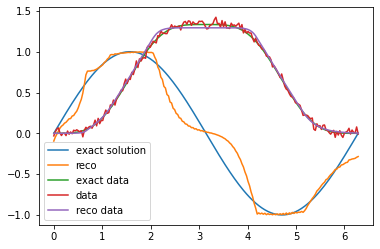

In [10]:
stoprule = (
    # Method is slow, so need to use large number of iterations
    rules.CountIterations(max_iterations=100000) +
    rules.Discrepancy(
        setting.Hcodomain.norm, data,
        noiselevel=setting.Hcodomain.norm(noise),
        tau=1.3
    )
)

reco, reco_data = solver.run(stoprule)

plt.plot(grid.coords[0], exact_solution.T, label='exact solution')
plt.plot(grid.coords[0], reco, label='reco')
plt.plot(grid.coords[0], exact_data, label='exact data')
plt.plot(grid.coords[0], data, label='data')
plt.plot(grid.coords[0], reco_data, label='reco data')
plt.legend()
plt.show()

The reconstructions shows the piece-wise constant and piece-wise smooth feature expected for TV-regularization.

Regpy and imagingbase provide a wide range of possible solvers: IRGNM_CG, Landweber, FISTA, ADMM, Douglas-Rashford, Forward-Backward Splitting, Gradient Descent, Arrow-Hurwisz-Uzawa. Additionally, there is a wrapper for all gradient based optimizer routines in scipy.optimize (imagingbase.solvers.scipy_solver.Minimize). 